In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   rimini
   2   chieti
   3   livorno
   4   alessandria
   5   ravenna
   6   salerno
   7   cuneo
   8   belluno
   9   treviso
   10   torino
   11   reggio_nell_emilia
   12   venezia
   13   arezzo
   14   roma
   15   asti
   16   ancona
   17   verbania
   18   terni
   19   foggia
   20   macerata
   21   vercelli
   22   vicenza
   23   campobasso
   24   cagliari
   25   crotone
   26   brescia
   27   pistoia
   28   carbonia
   29   gorizia
   30   forli
   31   latina
   32   bolzano
   33   teramo
   34   pavia
   35   trieste
   36   oristano
   37   bologna
   38   mantova
   39   perugia
   40   trapani
   41   verona
   42   messina
   43   siena
   44   potenza
   45   napoli
   46   agrigento
   47   imperia
   48   grosseto
   49   biella
   50   catania
   51   ragusa
   52   pescara
   53   parma
   54   ferrara
   55   massa
   56   reggio_di_calabria
   57   sondrio
   58   viterbo
 

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 rimini
2 chieti
3 livorno
4 alessandria
5 ravenna
6 salerno
7 cuneo
8 belluno
9 treviso
10 torino
11 reggio_nell_emilia
12 venezia
13 arezzo
14 roma
15 asti
16 ancona
17 verbania
18 terni
19 foggia
20 macerata
21 vercelli
22 vicenza
23 campobasso
24 cagliari
25 crotone
26 brescia
27 pistoia
28 gorizia
29 forli
30 latina
31 bolzano
32 teramo
33 pavia
34 trieste
35 oristano
36 bologna
37 mantova
38 perugia
39 trapani
40 verona
41 messina
42 siena
43 potenza
44 napoli
45 agrigento
46 imperia
47 grosseto
48 biella
49 catania
50 ragusa
51 pescara
52 parma
53 ferrara
54 massa
55 reggio_di_calabria
56 sondrio
57 viterbo
58 taranto
59 firenze
60 lecco
61 varese
62 avellino
63 caltanissetta
64 bat
65 rieti
66 udine
67 palermo
68 vibo_valentia
69 catanzaro
70 novara
71 cosenza
72 bergamo
73 milano
74 pisa
75 frosinone
76 rovigo
77 caserta
78 sassari
79 brindisi
80 cremona
81 ascoli_piceno
82 l_aquila
83 siracusa
84 fermo
85 pesaro
86 trento
87 padova
88 como
89 matera
90 lucca
91 genova
92 pra

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

A seguire i test cercando di minimizzare l'overfitting 

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 15, 'min_samples_leaf': 2, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.12302375588625258 0.8664254625344426 0.74340170664819
Training set average RMSE:  0.72863  0.03520 
    Test set average RMSE:  0.94704  0.08379 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.68540
                       R2:  0.78502


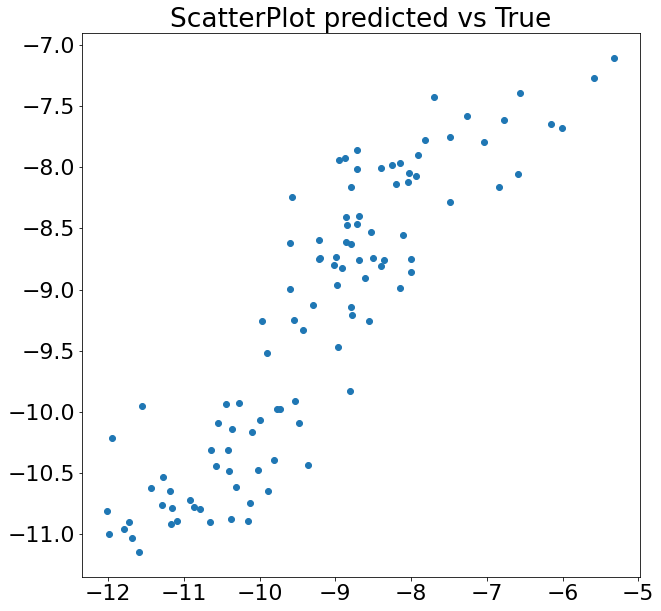

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02101
Feature:               commutersdensity, Score: 0.22101
Feature:                         depriv, Score: 0.12270
Feature:                            lat, Score: 0.28005
Feature:                 Ratio0200ver65, Score: 0.03765
Feature:         avg_wpm10_period1_2020, Score: 0.13575
Feature:           avg_wno_period1_2020, Score: 0.10569
Feature:         avg_wpans_period1_2020, Score: 0.01714
Feature:          avg_wso2_period1_2020, Score: 0.04274
Feature:                  randomfeature, Score: 0.01625


<Figure size 432x288 with 0 Axes>

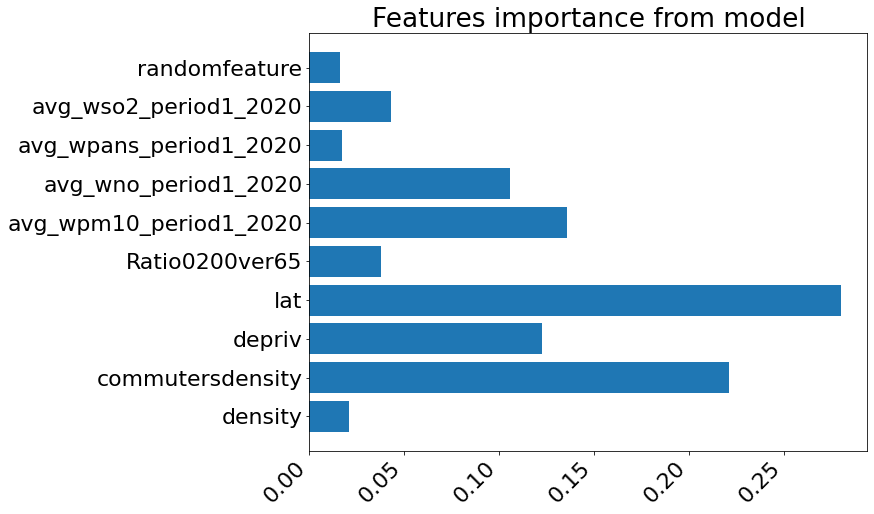

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05374 +/- 0.00529
Feature:               commutersdensity, Score: 0.02691 +/- 0.00387
Feature:                         depriv, Score: 0.04404 +/- 0.00484
Feature:                            lat, Score: 2.65658 +/- 0.35595
Feature:                 Ratio0200ver65, Score: 0.13168 +/- 0.02287
Feature:         avg_wpm10_period1_2020, Score: 0.17514 +/- 0.02401
Feature:           avg_wno_period1_2020, Score: 0.19589 +/- 0.02128
Feature:         avg_wpans_period1_2020, Score: 0.04682 +/- 0.00584
Feature:          avg_wso2_period1_2020, Score: 0.07176 +/- 0.00888
Feature:                  randomfeature, Score: 0.07533 +/- 0.01236


<Figure size 432x288 with 0 Axes>

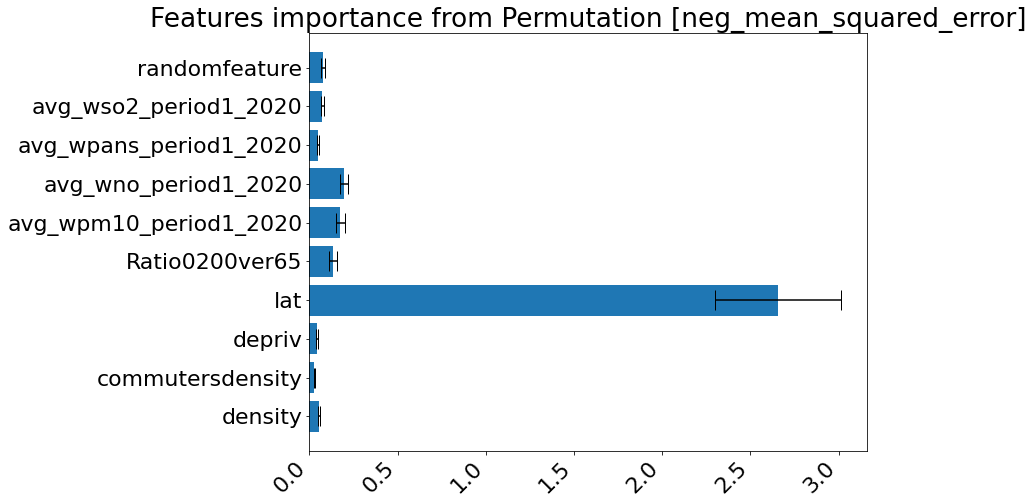

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02459 +/- 0.00242
Feature:               commutersdensity, Score: 0.01232 +/- 0.00177
Feature:                         depriv, Score: 0.02015 +/- 0.00222
Feature:                            lat, Score: 1.21569 +/- 0.16289
Feature:                 Ratio0200ver65, Score: 0.06026 +/- 0.01047
Feature:         avg_wpm10_period1_2020, Score: 0.08015 +/- 0.01099
Feature:           avg_wno_period1_2020, Score: 0.08964 +/- 0.00974
Feature:         avg_wpans_period1_2020, Score: 0.02143 +/- 0.00267
Feature:          avg_wso2_period1_2020, Score: 0.03284 +/- 0.00406
Feature:                  randomfeature, Score: 0.03447 +/- 0.00566


<Figure size 432x288 with 0 Axes>

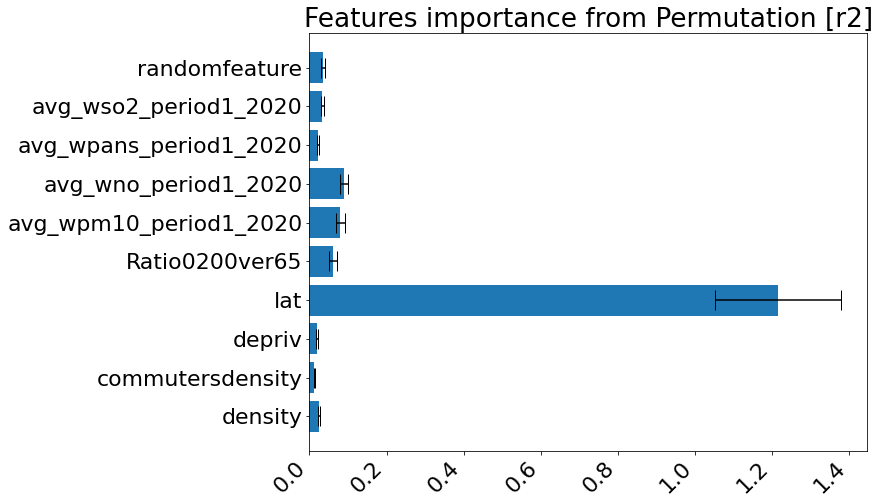

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00962 +/- 0.01625
Feature:               commutersdensity, Score: -0.02659 +/- 0.03437
Feature:                         depriv, Score: -0.07972 +/- 0.03720
Feature:                            lat, Score: 1.67948 +/- 0.38618
Feature:                 Ratio0200ver65, Score: 0.07350 +/- 0.11460
Feature:         avg_wpm10_period1_2020, Score: 0.02018 +/- 0.05098
Feature:           avg_wno_period1_2020, Score: 0.08667 +/- 0.03275
Feature:         avg_wpans_period1_2020, Score: -0.00373 +/- 0.01482
Feature:          avg_wso2_period1_2020, Score: -0.00752 +/- 0.01803
Feature:                  randomfeature, Score: 0.02247 +/- 0.02914


<Figure size 432x288 with 0 Axes>

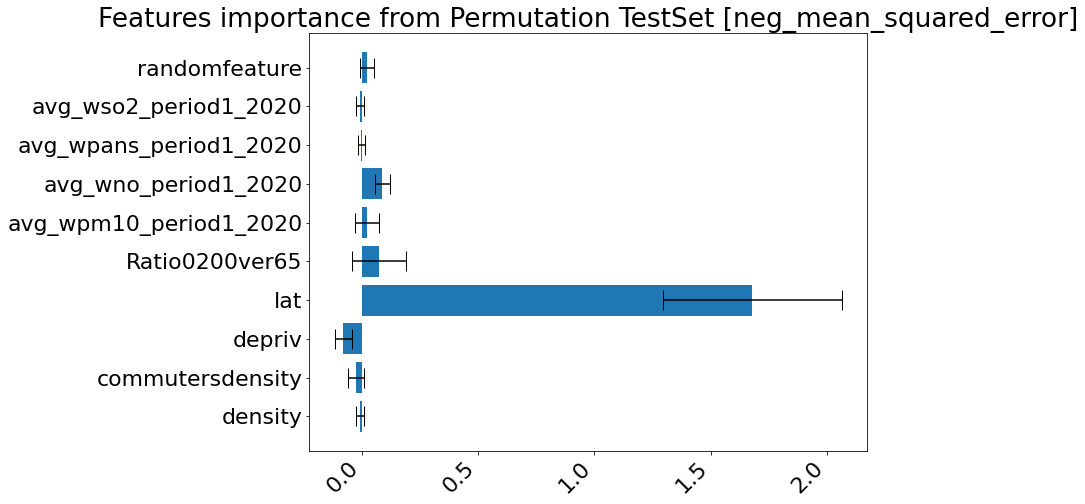

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00410 +/- 0.00693
Feature:               commutersdensity, Score: -0.01133 +/- 0.01465
Feature:                         depriv, Score: -0.03398 +/- 0.01586
Feature:                            lat, Score: 0.71592 +/- 0.16462
Feature:                 Ratio0200ver65, Score: 0.03133 +/- 0.04885
Feature:         avg_wpm10_period1_2020, Score: 0.00860 +/- 0.02173
Feature:           avg_wno_period1_2020, Score: 0.03695 +/- 0.01396
Feature:         avg_wpans_period1_2020, Score: -0.00159 +/- 0.00632
Feature:          avg_wso2_period1_2020, Score: -0.00321 +/- 0.00769
Feature:                  randomfeature, Score: 0.00958 +/- 0.01242


<Figure size 432x288 with 0 Axes>

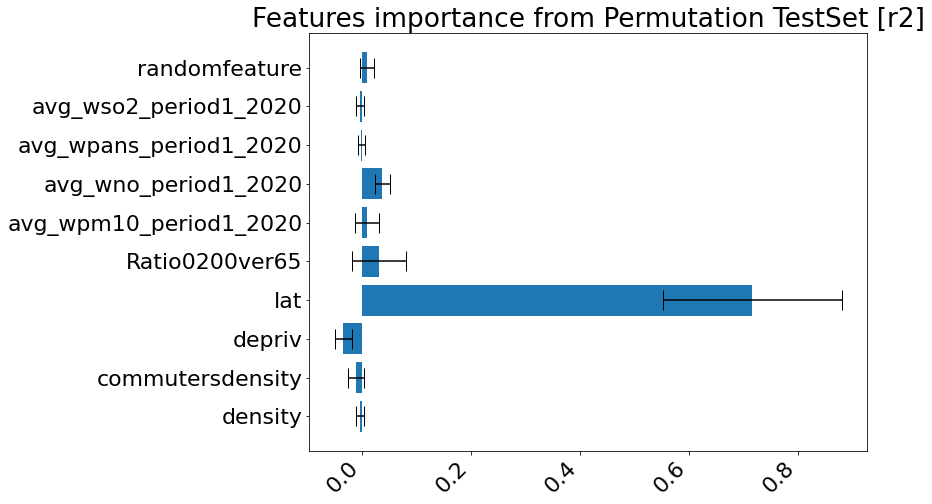

<Figure size 720x720 with 0 Axes>

((0.7286291846018854, 0.035198095622600886),
 (0.9470383084481881, 0.08379303042768539),
 0.6854042200693162,
 {'density': 0.0154518460715694,
  'commutersdensity': 0.007737961800246473,
  'depriv': 0.012662024204499163,
  'lat': 0.7638469339352019,
  'Ratio0200ver65': 0.037862948807690325,
  'avg_wpm10_period1_2020': 0.05035871564850919,
  'avg_wno_period1_2020': 0.056323464404917,
  'avg_wpans_period1_2020': 0.013463598727978988,
  'avg_wso2_period1_2020': 0.020633070451291046,
  'randomfeature': 0.021659435948096585},
 {'density': 0.015451846071569407,
  'commutersdensity': 0.007737961800246483,
  'depriv': 0.012662024204499174,
  'lat': 0.7638469339352018,
  'Ratio0200ver65': 0.03786294880769033,
  'avg_wpm10_period1_2020': 0.050358715648509196,
  'avg_wno_period1_2020': 0.056323464404917,
  'avg_wpans_period1_2020': 0.013463598727978997,
  'avg_wso2_period1_2020': 0.020633070451291063,
  'randomfeature': 0.021659435948096595},
 {'density': -0.005482821427699389,
  'commutersdensit

In [6]:
# here we test grid opt to get a model not overfitting 

importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_optoverfit", showplot=True, optimisedparams=besthyperF)

{'n_estimators': 800, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 2, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.1816111069973695 0.8804986244312638 0.6988875174338943
Training set average RMSE:  0.67026  0.03778 
    Test set average RMSE:  1.01968  0.09969 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.63540
                       R2:  0.81525


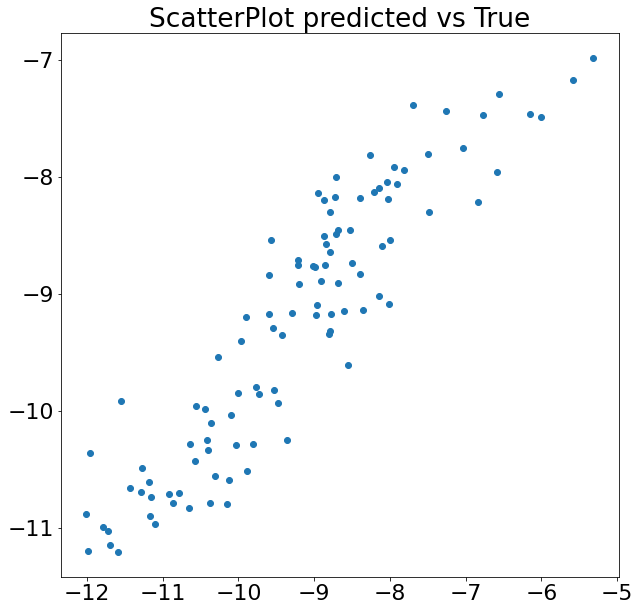

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04205
Feature:               commutersdensity, Score: 0.28239
Feature:                         depriv, Score: 0.14767
Feature:                 Ratio0200ver65, Score: 0.06389
Feature:         avg_wpm10_period1_2020, Score: 0.15457
Feature:           avg_wno_period1_2020, Score: 0.19269
Feature:         avg_wpans_period1_2020, Score: 0.03228
Feature:          avg_wso2_period1_2020, Score: 0.05501
Feature:                  randomfeature, Score: 0.02945


<Figure size 432x288 with 0 Axes>

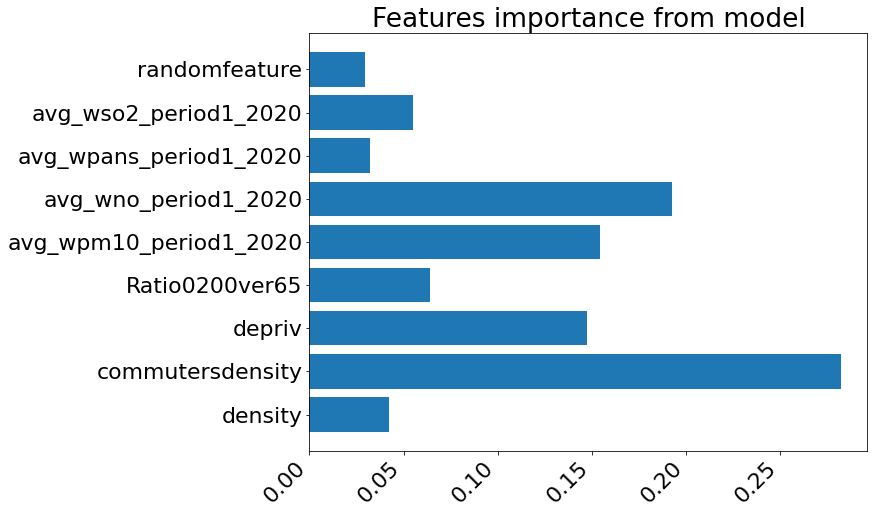

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05736 +/- 0.00491
Feature:               commutersdensity, Score: 1.74167 +/- 0.22102
Feature:                         depriv, Score: 0.06116 +/- 0.00742
Feature:                 Ratio0200ver65, Score: 0.23896 +/- 0.02733
Feature:         avg_wpm10_period1_2020, Score: 0.22513 +/- 0.02980
Feature:           avg_wno_period1_2020, Score: 0.35712 +/- 0.04131
Feature:         avg_wpans_period1_2020, Score: 0.07579 +/- 0.00781
Feature:          avg_wso2_period1_2020, Score: 0.09541 +/- 0.01066
Feature:                  randomfeature, Score: 0.08114 +/- 0.01167


<Figure size 432x288 with 0 Axes>

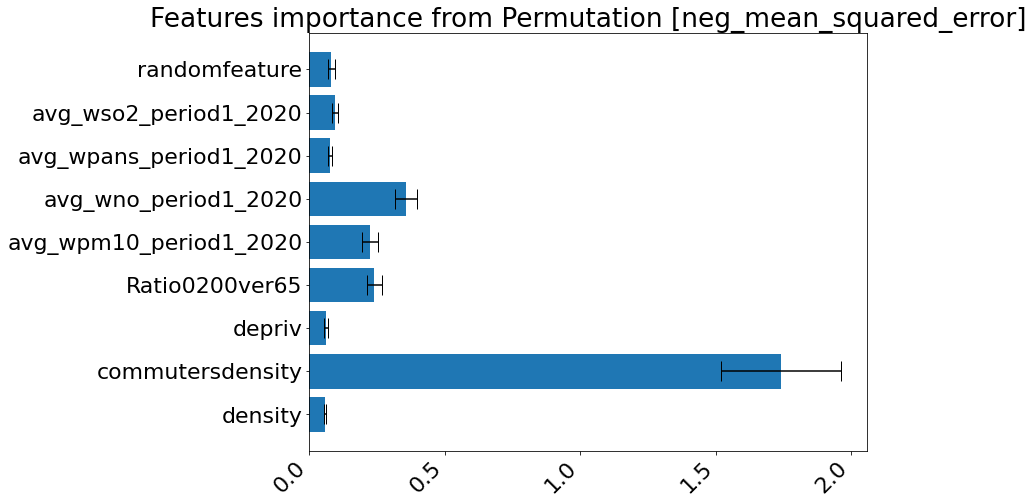

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02625 +/- 0.00225
Feature:               commutersdensity, Score: 0.79701 +/- 0.10114
Feature:                         depriv, Score: 0.02799 +/- 0.00340
Feature:                 Ratio0200ver65, Score: 0.10935 +/- 0.01251
Feature:         avg_wpm10_period1_2020, Score: 0.10302 +/- 0.01364
Feature:           avg_wno_period1_2020, Score: 0.16342 +/- 0.01890
Feature:         avg_wpans_period1_2020, Score: 0.03468 +/- 0.00357
Feature:          avg_wso2_period1_2020, Score: 0.04366 +/- 0.00488
Feature:                  randomfeature, Score: 0.03713 +/- 0.00534


<Figure size 432x288 with 0 Axes>

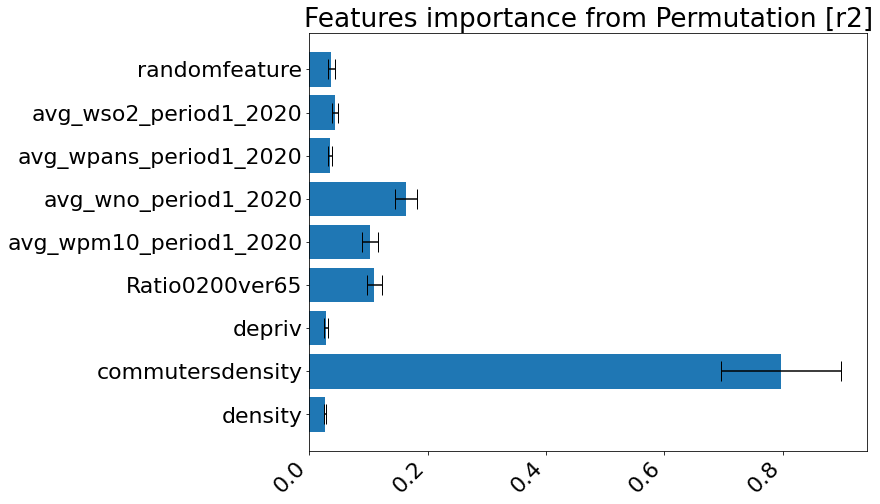

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00076 +/- 0.01117
Feature:               commutersdensity, Score: 0.95025 +/- 0.33544
Feature:                         depriv, Score: -0.09881 +/- 0.10906
Feature:                 Ratio0200ver65, Score: 0.22684 +/- 0.12397
Feature:         avg_wpm10_period1_2020, Score: 0.10512 +/- 0.07095
Feature:           avg_wno_period1_2020, Score: 0.17380 +/- 0.06461
Feature:         avg_wpans_period1_2020, Score: 0.02339 +/- 0.02797
Feature:          avg_wso2_period1_2020, Score: 0.01459 +/- 0.03145
Feature:                  randomfeature, Score: 0.02729 +/- 0.03876


<Figure size 432x288 with 0 Axes>

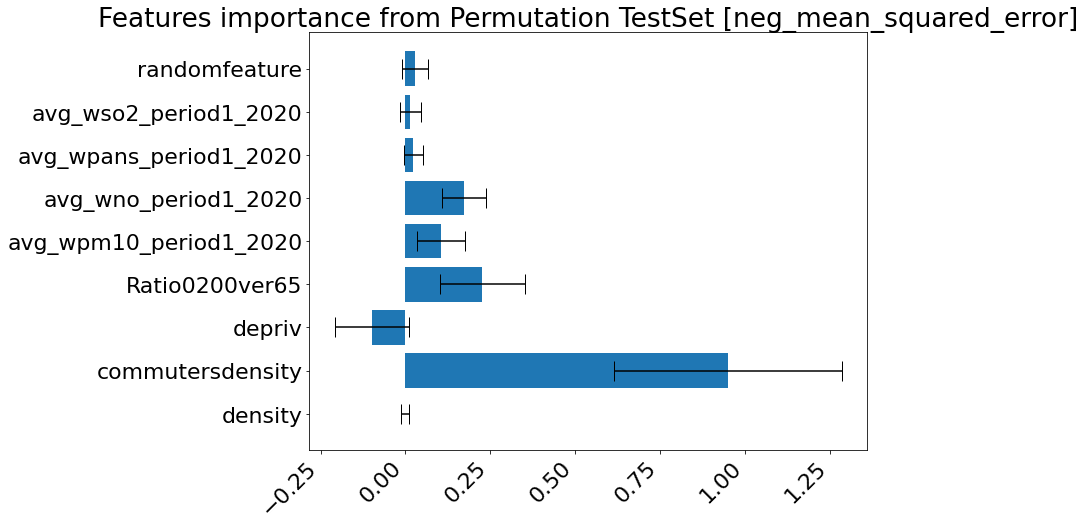

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00032 +/- 0.00476
Feature:               commutersdensity, Score: 0.40507 +/- 0.14299
Feature:                         depriv, Score: -0.04212 +/- 0.04649
Feature:                 Ratio0200ver65, Score: 0.09670 +/- 0.05285
Feature:         avg_wpm10_period1_2020, Score: 0.04481 +/- 0.03024
Feature:           avg_wno_period1_2020, Score: 0.07409 +/- 0.02754
Feature:         avg_wpans_period1_2020, Score: 0.00997 +/- 0.01192
Feature:          avg_wso2_period1_2020, Score: 0.00622 +/- 0.01341
Feature:                  randomfeature, Score: 0.01163 +/- 0.01652


<Figure size 432x288 with 0 Axes>

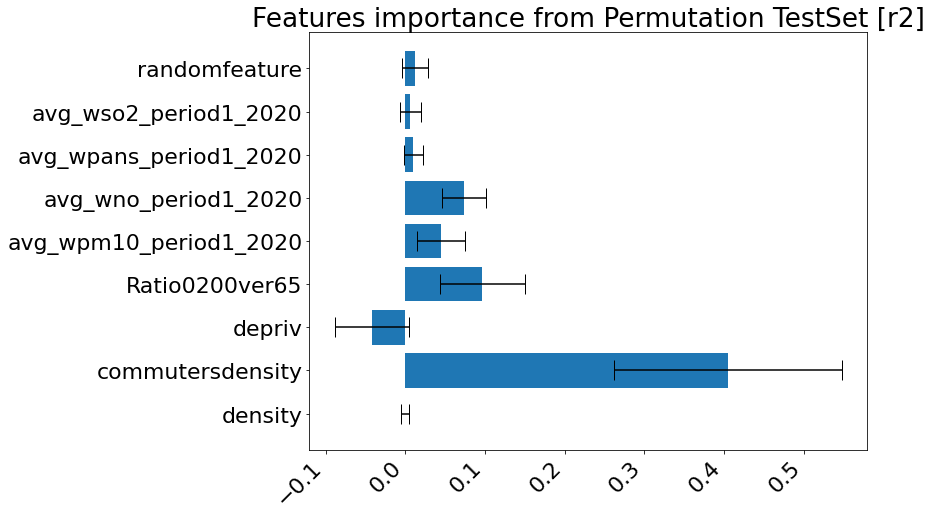

<Figure size 720x720 with 0 Axes>

((0.6702636656231056, 0.03778256442874263),
 (1.0196828309725623, 0.09968994545502718),
 0.6354014377725952,
 {'density': 0.019550735639093896,
  'commutersdensity': 0.593671279792494,
  'depriv': 0.02084566230111114,
  'Ratio0200ver65': 0.08145356734438018,
  'avg_wpm10_period1_2020': 0.07673845186211505,
  'avg_wno_period1_2020': 0.12172899840993633,
  'avg_wpans_period1_2020': 0.025834322329922457,
  'avg_wso2_period1_2020': 0.032520337504378174,
  'randomfeature': 0.027656644816568588},
 {'density': 0.019550735639093902,
  'commutersdensity': 0.5936712797924942,
  'depriv': 0.020845662301111144,
  'Ratio0200ver65': 0.08145356734438021,
  'avg_wpm10_period1_2020': 0.07673845186211507,
  'avg_wno_period1_2020': 0.12172899840993634,
  'avg_wpans_period1_2020': 0.025834322329922457,
  'avg_wso2_period1_2020': 0.03252033750437818,
  'randomfeature': 0.0276566448165686},
 {'density': -0.0005324459747516551,
  'commutersdensity': 0.6683864860548135,
  'depriv': -0.06949996589399264,
  'Ra

In [7]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_optoverfit", showplot=True, optimisedparams=besthyperF )

{'n_estimators': 300, 'max_depth': None, 'min_samples_split': 15, 'min_samples_leaf': 2, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.25062375200882525 1.0891741204624095 0.8385503684535842
Training set average RMSE:  0.82844  0.05151 
    Test set average RMSE:  1.13843  0.12250 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.79191
                       R2:  0.71302


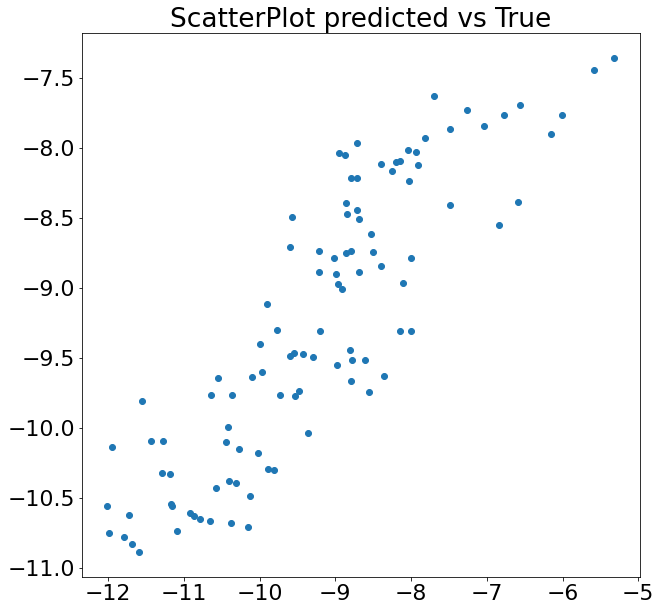

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05956
Feature:                         depriv, Score: 0.20920
Feature:                 Ratio0200ver65, Score: 0.07443
Feature:         avg_wpm10_period1_2020, Score: 0.21599
Feature:           avg_wno_period1_2020, Score: 0.26897
Feature:         avg_wpans_period1_2020, Score: 0.04961
Feature:          avg_wso2_period1_2020, Score: 0.08766
Feature:                  randomfeature, Score: 0.03459


<Figure size 432x288 with 0 Axes>

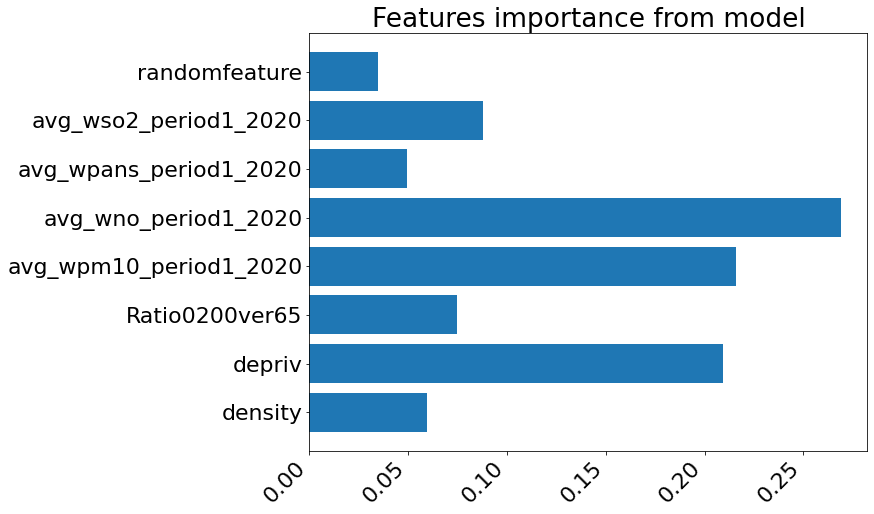

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06734 +/- 0.00644
Feature:                         depriv, Score: 0.57783 +/- 0.07164
Feature:                 Ratio0200ver65, Score: 0.18634 +/- 0.02445
Feature:         avg_wpm10_period1_2020, Score: 0.45290 +/- 0.06168
Feature:           avg_wno_period1_2020, Score: 0.87529 +/- 0.10516
Feature:         avg_wpans_period1_2020, Score: 0.15406 +/- 0.01783
Feature:          avg_wso2_period1_2020, Score: 0.12397 +/- 0.01341
Feature:                  randomfeature, Score: 0.06334 +/- 0.00903


<Figure size 432x288 with 0 Axes>

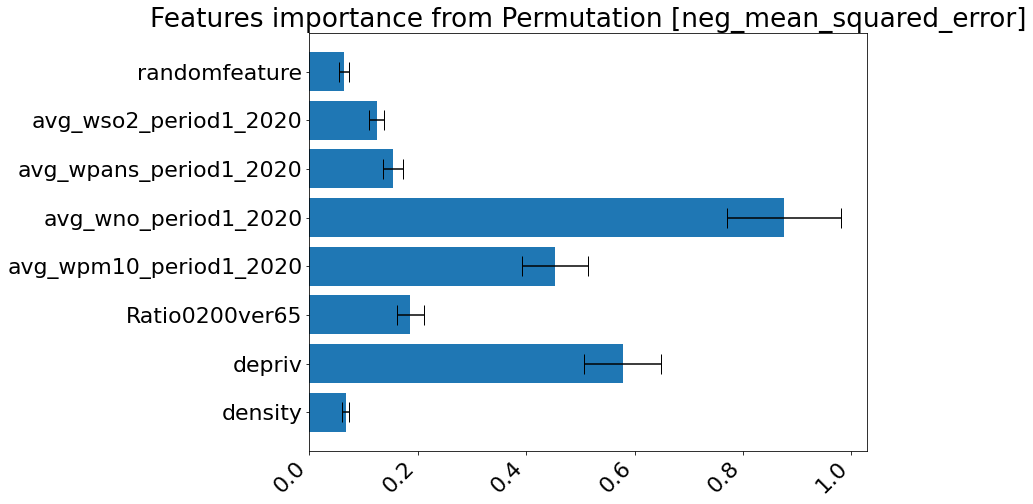

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03081 +/- 0.00295
Feature:                         depriv, Score: 0.26442 +/- 0.03278
Feature:                 Ratio0200ver65, Score: 0.08527 +/- 0.01119
Feature:         avg_wpm10_period1_2020, Score: 0.20726 +/- 0.02822
Feature:           avg_wno_period1_2020, Score: 0.40055 +/- 0.04812
Feature:         avg_wpans_period1_2020, Score: 0.07050 +/- 0.00816
Feature:          avg_wso2_period1_2020, Score: 0.05673 +/- 0.00614
Feature:                  randomfeature, Score: 0.02899 +/- 0.00413


<Figure size 432x288 with 0 Axes>

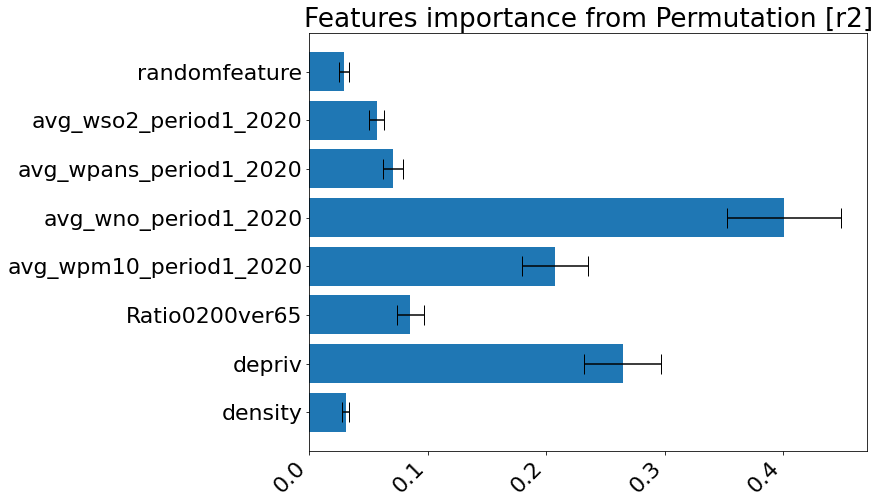

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.08459 +/- 0.03168
Feature:                         depriv, Score: 0.01882 +/- 0.42083
Feature:                 Ratio0200ver65, Score: 0.02522 +/- 0.10891
Feature:         avg_wpm10_period1_2020, Score: 0.20193 +/- 0.10955
Feature:           avg_wno_period1_2020, Score: 0.34831 +/- 0.16784
Feature:         avg_wpans_period1_2020, Score: 0.03134 +/- 0.03091
Feature:          avg_wso2_period1_2020, Score: 0.05130 +/- 0.02727
Feature:                  randomfeature, Score: -0.00004 +/- 0.02933


<Figure size 432x288 with 0 Axes>

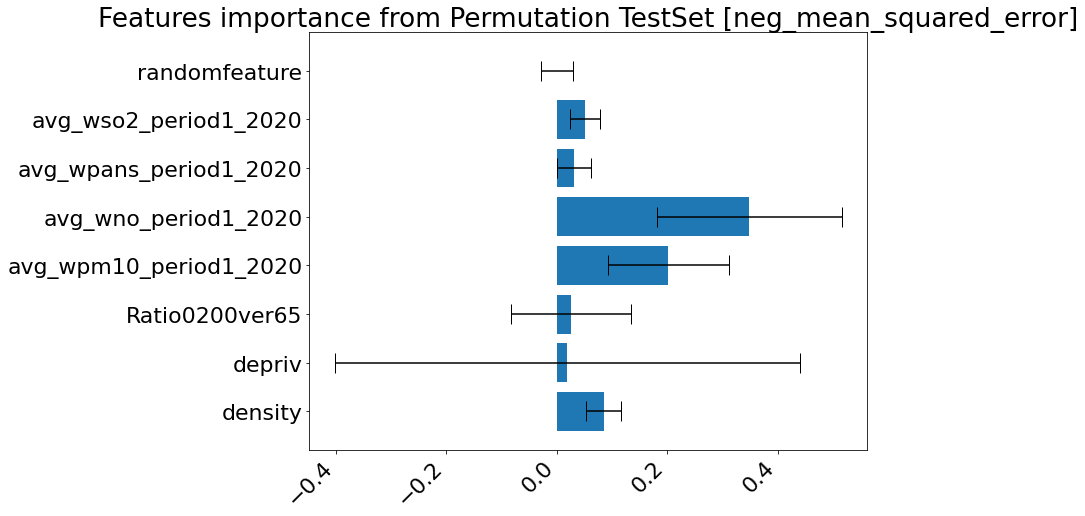

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.03606 +/- 0.01350
Feature:                         depriv, Score: 0.00802 +/- 0.17939
Feature:                 Ratio0200ver65, Score: 0.01075 +/- 0.04643
Feature:         avg_wpm10_period1_2020, Score: 0.08608 +/- 0.04670
Feature:           avg_wno_period1_2020, Score: 0.14848 +/- 0.07154
Feature:         avg_wpans_period1_2020, Score: 0.01336 +/- 0.01318
Feature:          avg_wso2_period1_2020, Score: 0.02187 +/- 0.01162
Feature:                  randomfeature, Score: -0.00002 +/- 0.01250


<Figure size 432x288 with 0 Axes>

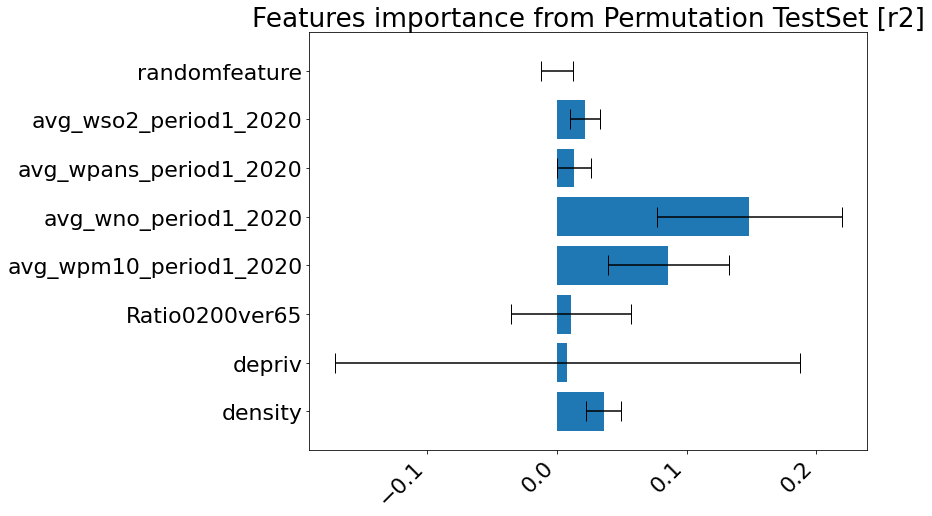

<Figure size 720x720 with 0 Axes>

((0.828443889768896, 0.05150991468278194),
 (1.1384313125843513, 0.12249964948460312),
 0.7919114924570596,
 {'density': 0.026922523238709764,
  'depriv': 0.23103346472208092,
  'Ratio0200ver65': 0.07450315375183339,
  'avg_wpm10_period1_2020': 0.18108356326350317,
  'avg_wno_period1_2020': 0.34996628331175206,
  'avg_wpans_period1_2020': 0.06159706532484783,
  'avg_wso2_period1_2020': 0.04956696720274003,
  'randomfeature': 0.025326979184532764},
 {'density': 0.026922523238709733,
  'depriv': 0.23103346472208103,
  'Ratio0200ver65': 0.0745031537518334,
  'avg_wpm10_period1_2020': 0.1810835632635032,
  'avg_wno_period1_2020': 0.3499662833117521,
  'avg_wpans_period1_2020': 0.0615970653248478,
  'avg_wso2_period1_2020': 0.049566967202740016,
  'randomfeature': 0.025326979184532743},
 {'density': 0.11109068208652881,
  'depriv': 0.024712072307302206,
  'Ratio0200ver65': 0.033120308666401775,
  'avg_wpm10_period1_2020': 0.26518222397996055,
  'avg_wno_period1_2020': 0.45741425439764444,
 

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_optoverfit", showplot=True, optimisedparams=besthyperF)

A seguire cercando di minimizzare invece RMSE su intero set

{'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.1109465990605849
Training set average RMSE:  0.34643  0.02037 
    Test set average RMSE:  0.94856  0.08635 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33309
                       R2:  0.94923


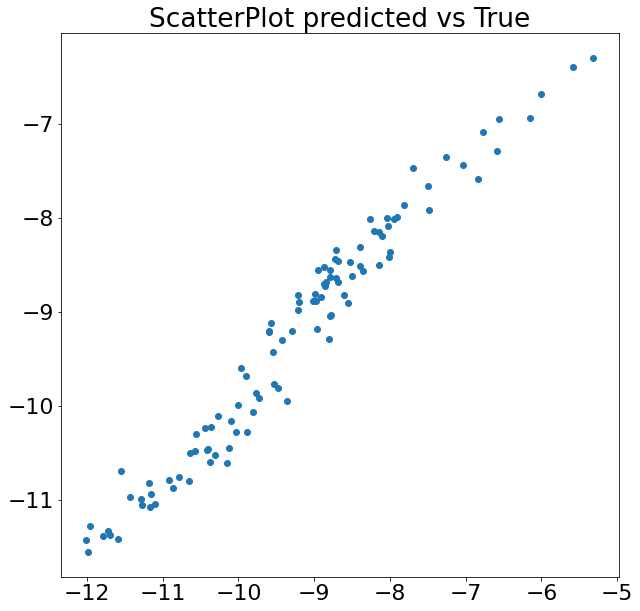

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04075
Feature:               commutersdensity, Score: 0.18465
Feature:                         depriv, Score: 0.09122
Feature:                            lat, Score: 0.25904
Feature:                 Ratio0200ver65, Score: 0.05753
Feature:         avg_wpm10_period1_2020, Score: 0.11792
Feature:           avg_wno_period1_2020, Score: 0.12883
Feature:         avg_wpans_period1_2020, Score: 0.03459
Feature:          avg_wso2_period1_2020, Score: 0.04622
Feature:                  randomfeature, Score: 0.03924


<Figure size 432x288 with 0 Axes>

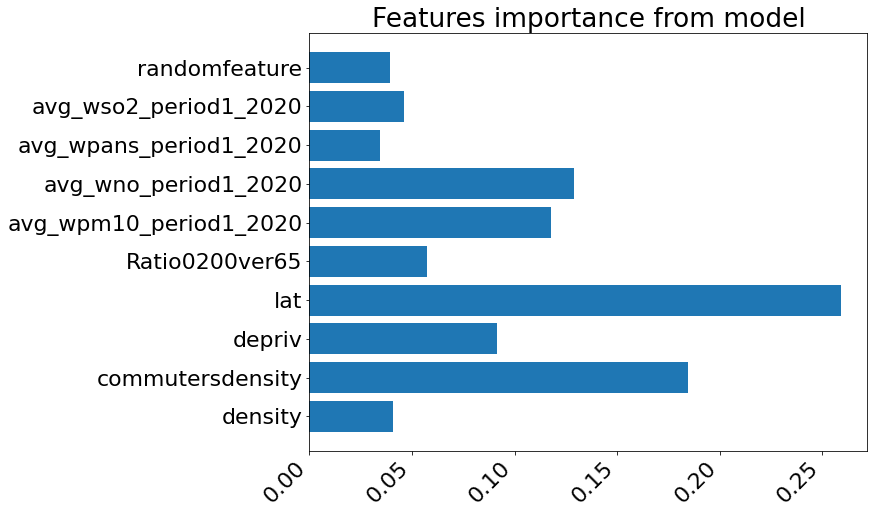

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04144 +/- 0.00421
Feature:               commutersdensity, Score: 0.03969 +/- 0.00558
Feature:                         depriv, Score: 0.05721 +/- 0.00602
Feature:                            lat, Score: 2.81227 +/- 0.36515
Feature:                 Ratio0200ver65, Score: 0.12769 +/- 0.02264
Feature:         avg_wpm10_period1_2020, Score: 0.14970 +/- 0.01861
Feature:           avg_wno_period1_2020, Score: 0.19421 +/- 0.02220
Feature:         avg_wpans_period1_2020, Score: 0.03914 +/- 0.00468
Feature:          avg_wso2_period1_2020, Score: 0.06634 +/- 0.00855
Feature:                  randomfeature, Score: 0.08060 +/- 0.01297


<Figure size 432x288 with 0 Axes>

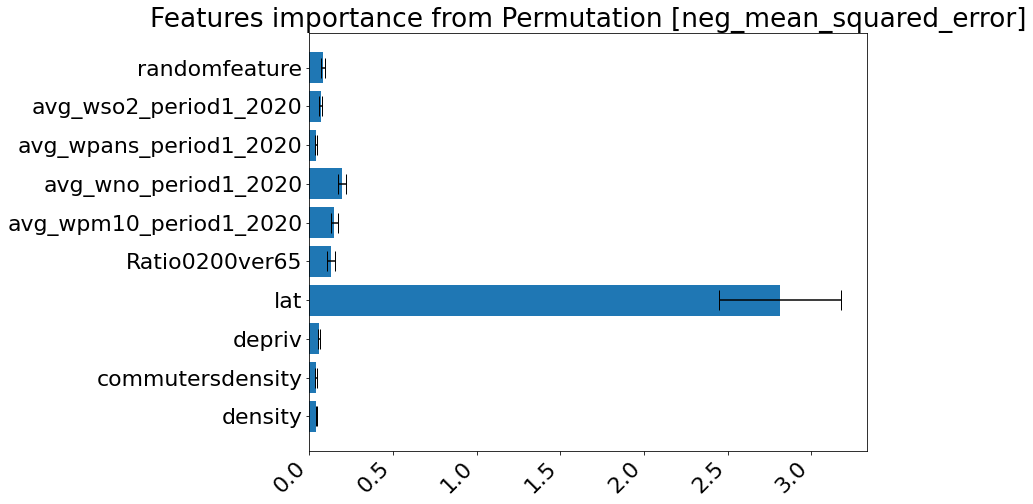

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01896 +/- 0.00192
Feature:               commutersdensity, Score: 0.01816 +/- 0.00255
Feature:                         depriv, Score: 0.02618 +/- 0.00275
Feature:                            lat, Score: 1.28693 +/- 0.16710
Feature:                 Ratio0200ver65, Score: 0.05843 +/- 0.01036
Feature:         avg_wpm10_period1_2020, Score: 0.06851 +/- 0.00852
Feature:           avg_wno_period1_2020, Score: 0.08887 +/- 0.01016
Feature:         avg_wpans_period1_2020, Score: 0.01791 +/- 0.00214
Feature:          avg_wso2_period1_2020, Score: 0.03036 +/- 0.00391
Feature:                  randomfeature, Score: 0.03688 +/- 0.00593


<Figure size 432x288 with 0 Axes>

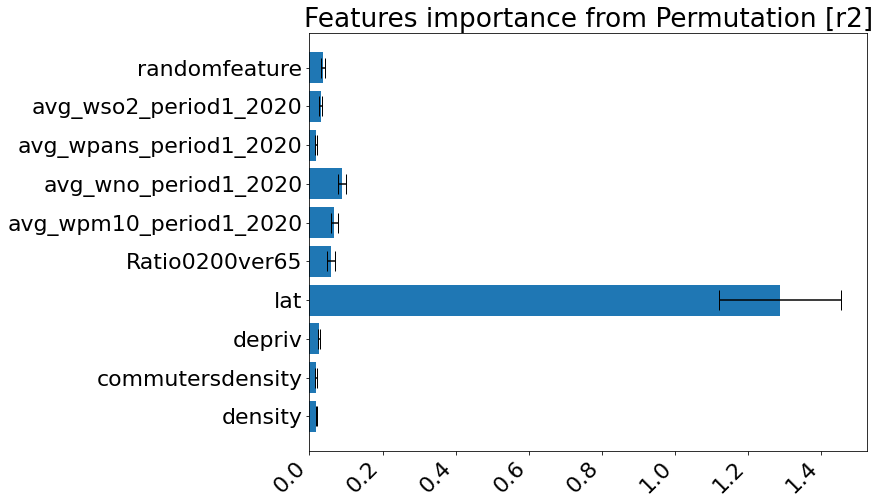

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.02147 +/- 0.02016
Feature:               commutersdensity, Score: -0.00454 +/- 0.03899
Feature:                         depriv, Score: -0.07370 +/- 0.03361
Feature:                            lat, Score: 1.67615 +/- 0.37372
Feature:                 Ratio0200ver65, Score: 0.06784 +/- 0.08452
Feature:         avg_wpm10_period1_2020, Score: 0.03238 +/- 0.05799
Feature:           avg_wno_period1_2020, Score: 0.06285 +/- 0.02592
Feature:         avg_wpans_period1_2020, Score: -0.01178 +/- 0.02077
Feature:          avg_wso2_period1_2020, Score: 0.00620 +/- 0.01624
Feature:                  randomfeature, Score: 0.03622 +/- 0.02668


<Figure size 432x288 with 0 Axes>

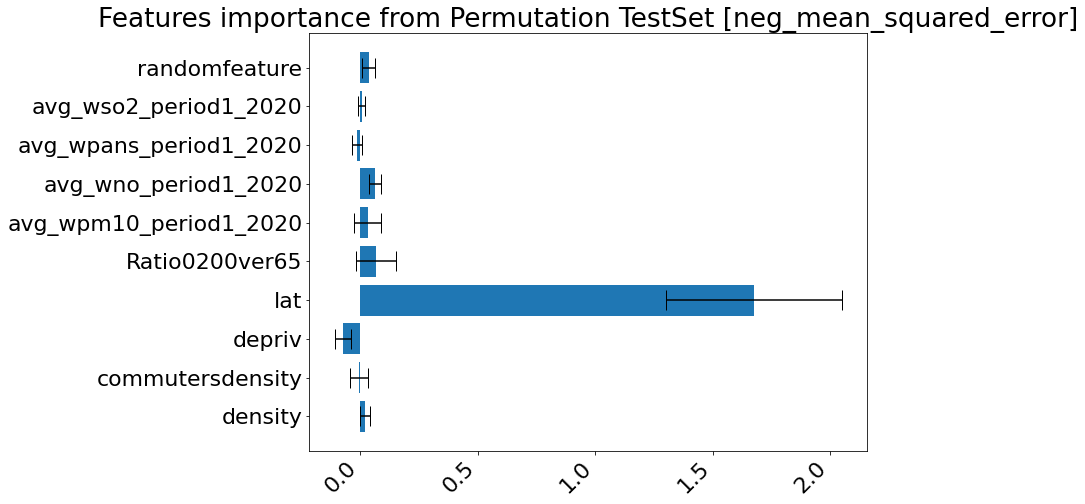

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00915 +/- 0.00859
Feature:               commutersdensity, Score: -0.00194 +/- 0.01662
Feature:                         depriv, Score: -0.03142 +/- 0.01433
Feature:                            lat, Score: 0.71450 +/- 0.15931
Feature:                 Ratio0200ver65, Score: 0.02892 +/- 0.03603
Feature:         avg_wpm10_period1_2020, Score: 0.01380 +/- 0.02472
Feature:           avg_wno_period1_2020, Score: 0.02679 +/- 0.01105
Feature:         avg_wpans_period1_2020, Score: -0.00502 +/- 0.00885
Feature:          avg_wso2_period1_2020, Score: 0.00264 +/- 0.00692
Feature:                  randomfeature, Score: 0.01544 +/- 0.01137


<Figure size 432x288 with 0 Axes>

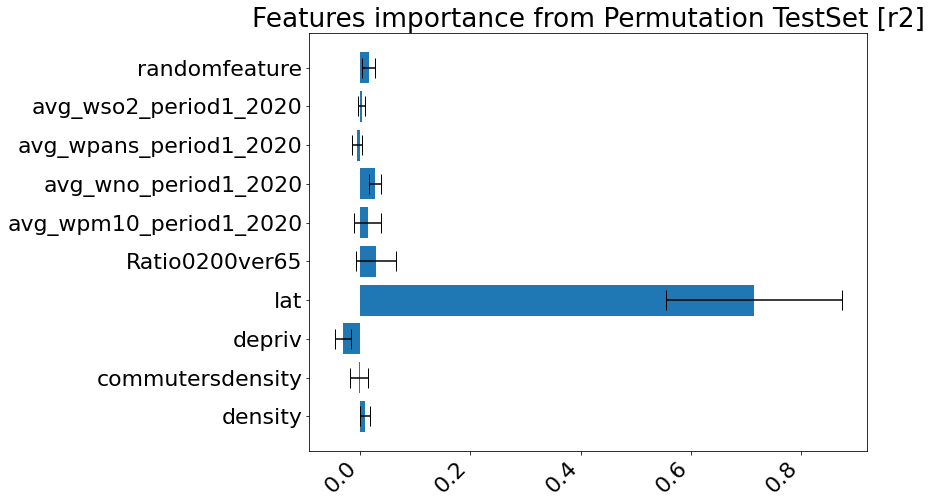

<Figure size 720x720 with 0 Axes>

((0.3464336897009619, 0.020365566137944918),
 (0.9485553718506714, 0.08634595021439434),
 0.3330864738481359,
 {'density': 0.011484393922808053,
  'commutersdensity': 0.011001058062819737,
  'depriv': 0.015854309521795555,
  'lat': 0.7793930662068189,
  'Ratio0200ver65': 0.035386710896367926,
  'avg_wpm10_period1_2020': 0.04148899197189961,
  'avg_wno_period1_2020': 0.05382265868295845,
  'avg_wpans_period1_2020': 0.010846751389392548,
  'avg_wso2_period1_2020': 0.018384529874813597,
  'randomfeature': 0.022337529470325673},
 {'density': 0.011484393922808048,
  'commutersdensity': 0.011001058062819735,
  'depriv': 0.015854309521795555,
  'lat': 0.7793930662068189,
  'Ratio0200ver65': 0.03538671089636793,
  'avg_wpm10_period1_2020': 0.04148899197189963,
  'avg_wno_period1_2020': 0.053822658682958456,
  'avg_wpans_period1_2020': 0.010846751389392542,
  'avg_wso2_period1_2020': 0.018384529874813604,
  'randomfeature': 0.022337529470325673},
 {'density': 0.011841207831567028,
  'commutersd

In [9]:
# here we test grid opt to get a model not overfitting 

importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(besthyperF, best_rmse)
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_optoallset", showplot=True, optimisedparams=besthyperF)

{'n_estimators': 800, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.12823125536361255
Training set average RMSE:  0.37067  0.02526 
    Test set average RMSE:  1.01667  0.10207 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35809
                       R2:  0.94132


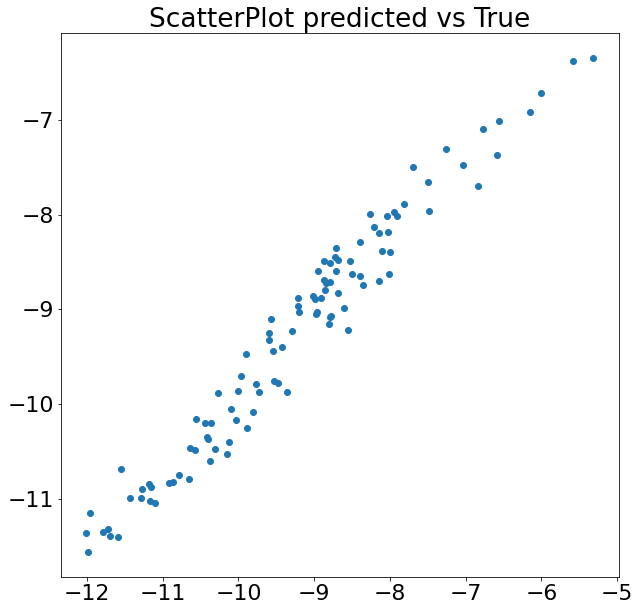

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05111
Feature:               commutersdensity, Score: 0.24309
Feature:                         depriv, Score: 0.13910
Feature:                 Ratio0200ver65, Score: 0.07426
Feature:         avg_wpm10_period1_2020, Score: 0.15748
Feature:           avg_wno_period1_2020, Score: 0.17811
Feature:         avg_wpans_period1_2020, Score: 0.04633
Feature:          avg_wso2_period1_2020, Score: 0.06409
Feature:                  randomfeature, Score: 0.04643


<Figure size 432x288 with 0 Axes>

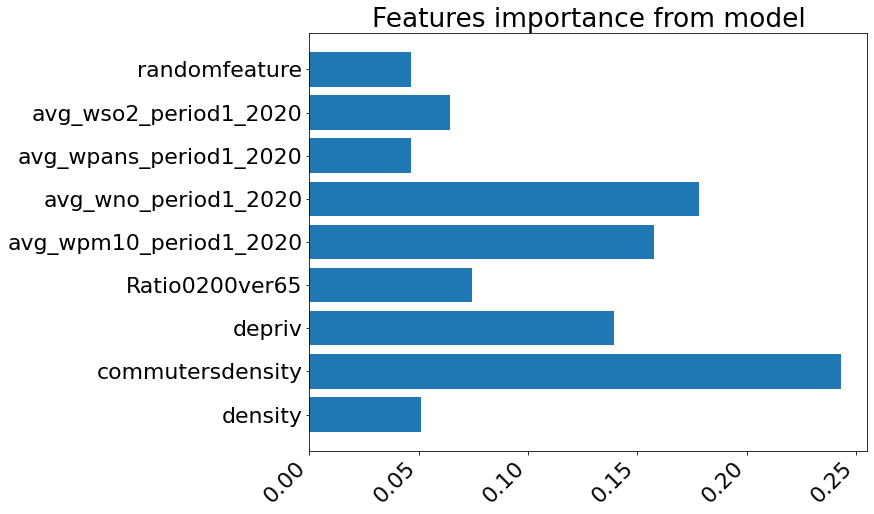

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05872 +/- 0.00575
Feature:               commutersdensity, Score: 1.67086 +/- 0.22302
Feature:                         depriv, Score: 0.05717 +/- 0.00635
Feature:                 Ratio0200ver65, Score: 0.20974 +/- 0.02565
Feature:         avg_wpm10_period1_2020, Score: 0.25298 +/- 0.03343
Feature:           avg_wno_period1_2020, Score: 0.34563 +/- 0.03923
Feature:         avg_wpans_period1_2020, Score: 0.07753 +/- 0.00842
Feature:          avg_wso2_period1_2020, Score: 0.10906 +/- 0.01341
Feature:                  randomfeature, Score: 0.07085 +/- 0.00963


<Figure size 432x288 with 0 Axes>

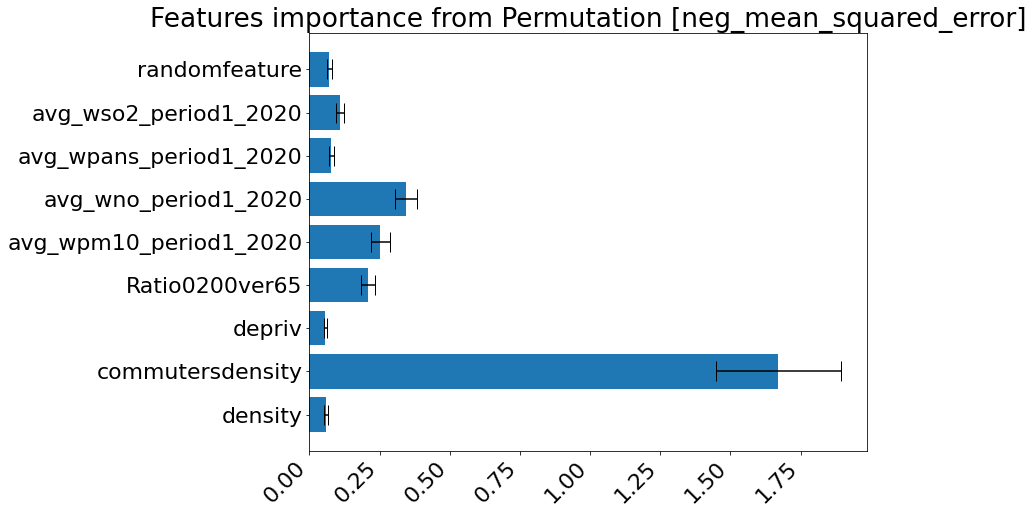

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02687 +/- 0.00263
Feature:               commutersdensity, Score: 0.76461 +/- 0.10206
Feature:                         depriv, Score: 0.02616 +/- 0.00291
Feature:                 Ratio0200ver65, Score: 0.09598 +/- 0.01174
Feature:         avg_wpm10_period1_2020, Score: 0.11577 +/- 0.01530
Feature:           avg_wno_period1_2020, Score: 0.15816 +/- 0.01795
Feature:         avg_wpans_period1_2020, Score: 0.03548 +/- 0.00385
Feature:          avg_wso2_period1_2020, Score: 0.04991 +/- 0.00614
Feature:                  randomfeature, Score: 0.03242 +/- 0.00441


<Figure size 432x288 with 0 Axes>

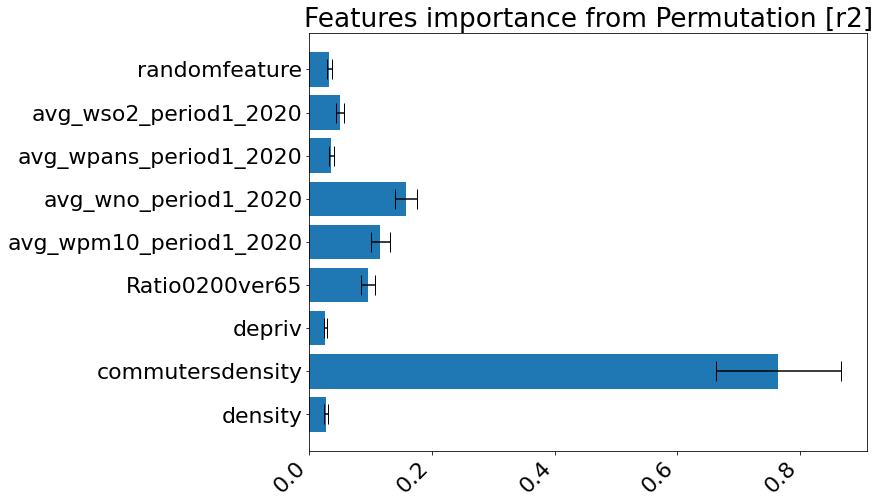

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00846 +/- 0.01764
Feature:               commutersdensity, Score: 1.00289 +/- 0.33695
Feature:                         depriv, Score: -0.14267 +/- 0.11137
Feature:                 Ratio0200ver65, Score: 0.29028 +/- 0.15161
Feature:         avg_wpm10_period1_2020, Score: 0.16943 +/- 0.11427
Feature:           avg_wno_period1_2020, Score: 0.15101 +/- 0.05468
Feature:         avg_wpans_period1_2020, Score: 0.03903 +/- 0.03837
Feature:          avg_wso2_period1_2020, Score: 0.04919 +/- 0.03118
Feature:                  randomfeature, Score: 0.03300 +/- 0.03808


<Figure size 432x288 with 0 Axes>

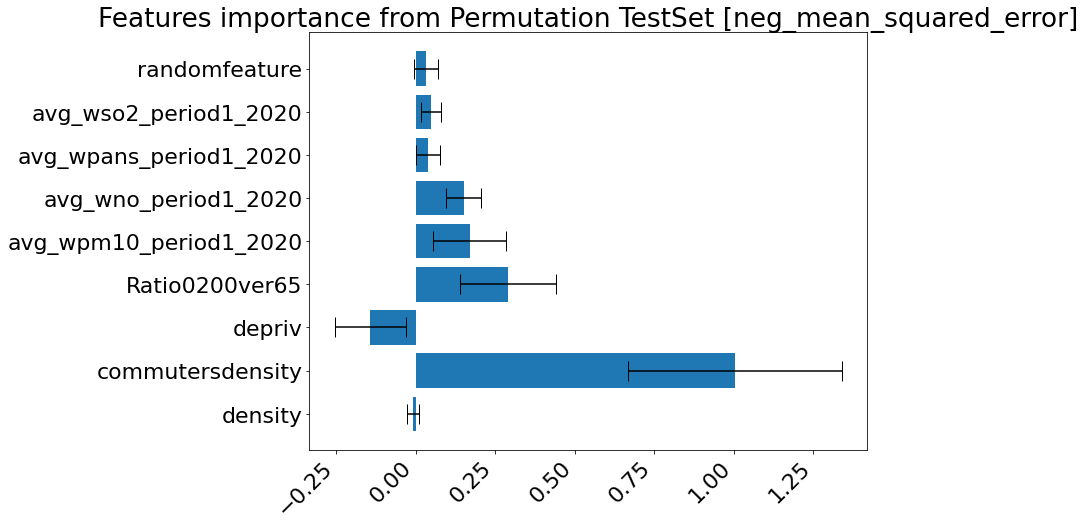

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00361 +/- 0.00752
Feature:               commutersdensity, Score: 0.42751 +/- 0.14363
Feature:                         depriv, Score: -0.06082 +/- 0.04748
Feature:                 Ratio0200ver65, Score: 0.12374 +/- 0.06463
Feature:         avg_wpm10_period1_2020, Score: 0.07222 +/- 0.04871
Feature:           avg_wno_period1_2020, Score: 0.06437 +/- 0.02331
Feature:         avg_wpans_period1_2020, Score: 0.01664 +/- 0.01636
Feature:          avg_wso2_period1_2020, Score: 0.02097 +/- 0.01329
Feature:                  randomfeature, Score: 0.01406 +/- 0.01623


<Figure size 432x288 with 0 Axes>

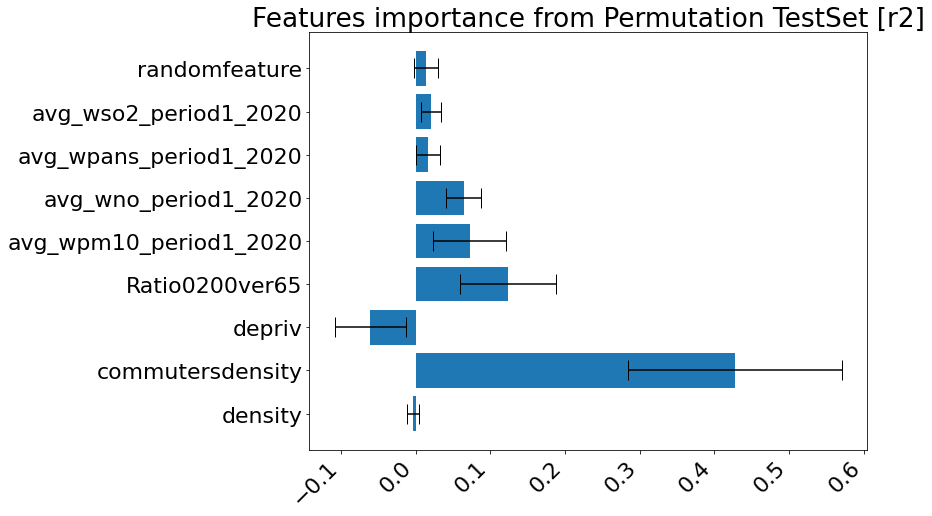

<Figure size 720x720 with 0 Axes>

((0.3706737791112995, 0.025258687781960817),
 (1.0166697074189337, 0.10207203038385239),
 0.35809391975236404,
 {'density': 0.02058492855156215,
  'commutersdensity': 0.5857456750836532,
  'depriv': 0.020042774569312274,
  'Ratio0200ver65': 0.07352667225200872,
  'avg_wpm10_period1_2020': 0.08868520828273063,
  'avg_wno_period1_2020': 0.12116506867749831,
  'avg_wpans_period1_2020': 0.02717825750667624,
  'avg_wso2_period1_2020': 0.03823246877988026,
  'randomfeature': 0.02483894629667822},
 {'density': 0.02058492855156211,
  'commutersdensity': 0.5857456750836534,
  'depriv': 0.02004277456931224,
  'Ratio0200ver65': 0.07352667225200873,
  'avg_wpm10_period1_2020': 0.08868520828273059,
  'avg_wno_period1_2020': 0.12116506867749832,
  'avg_wpans_period1_2020': 0.027178257506676205,
  'avg_wso2_period1_2020': 0.03823246877988023,
  'randomfeature': 0.0248389462966782},
 {'density': -0.005340735590151102,
  'commutersdensity': 0.6332571176075578,
  'depriv': -0.09008653742071826,
  'Ratio

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(besthyperF, best_rmse)

importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_optallset", showplot=True, optimisedparams=besthyperF )

{'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.14495342468535144
Training set average RMSE:  0.39479  0.02159 
    Test set average RMSE:  1.08299  0.09394 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38073
                       R2:  0.93367


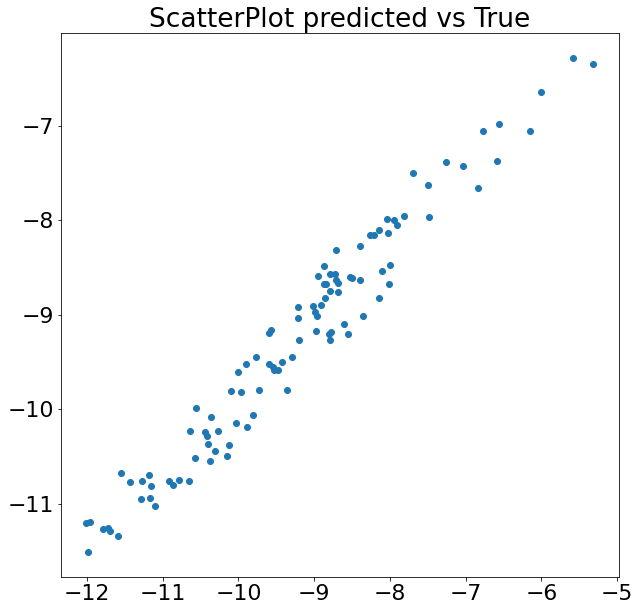

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07019
Feature:                         depriv, Score: 0.18734
Feature:                 Ratio0200ver65, Score: 0.09118
Feature:         avg_wpm10_period1_2020, Score: 0.19297
Feature:           avg_wno_period1_2020, Score: 0.22520
Feature:         avg_wpans_period1_2020, Score: 0.06602
Feature:          avg_wso2_period1_2020, Score: 0.10193
Feature:                  randomfeature, Score: 0.06516


<Figure size 432x288 with 0 Axes>

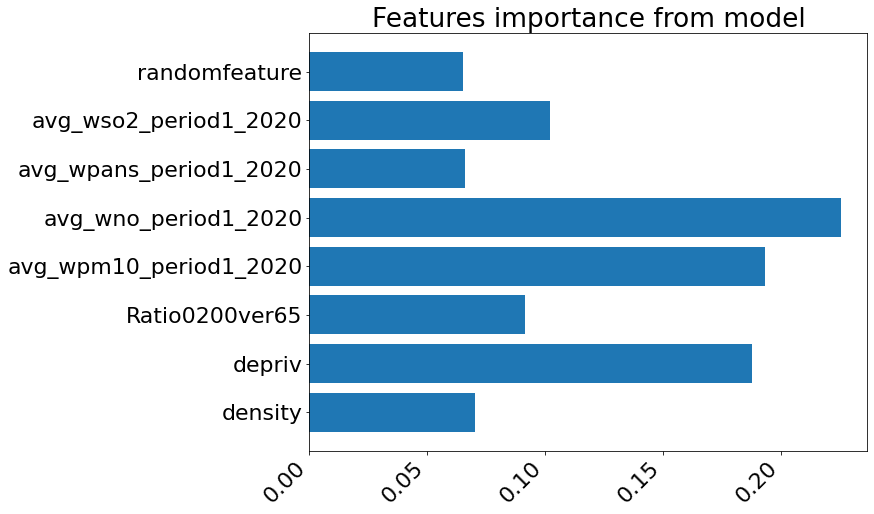

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07830 +/- 0.00834
Feature:                         depriv, Score: 0.70630 +/- 0.08929
Feature:                 Ratio0200ver65, Score: 0.15661 +/- 0.01951
Feature:         avg_wpm10_period1_2020, Score: 0.38881 +/- 0.05523
Feature:           avg_wno_period1_2020, Score: 0.84052 +/- 0.10703
Feature:         avg_wpans_period1_2020, Score: 0.13404 +/- 0.01739
Feature:          avg_wso2_period1_2020, Score: 0.12503 +/- 0.01226
Feature:                  randomfeature, Score: 0.07136 +/- 0.01053


<Figure size 432x288 with 0 Axes>

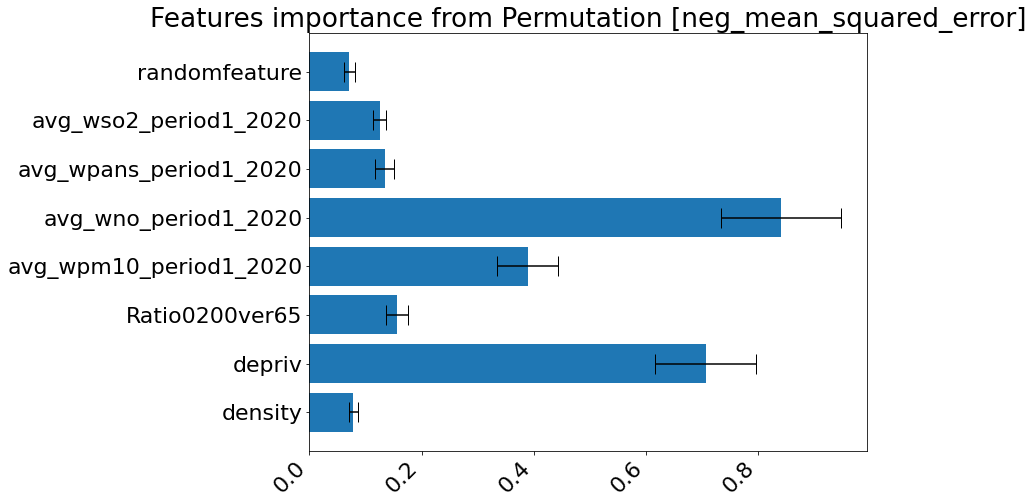

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03583 +/- 0.00382
Feature:                         depriv, Score: 0.32321 +/- 0.04086
Feature:                 Ratio0200ver65, Score: 0.07167 +/- 0.00893
Feature:         avg_wpm10_period1_2020, Score: 0.17793 +/- 0.02527
Feature:           avg_wno_period1_2020, Score: 0.38463 +/- 0.04898
Feature:         avg_wpans_period1_2020, Score: 0.06134 +/- 0.00796
Feature:          avg_wso2_period1_2020, Score: 0.05721 +/- 0.00561
Feature:                  randomfeature, Score: 0.03265 +/- 0.00482


<Figure size 432x288 with 0 Axes>

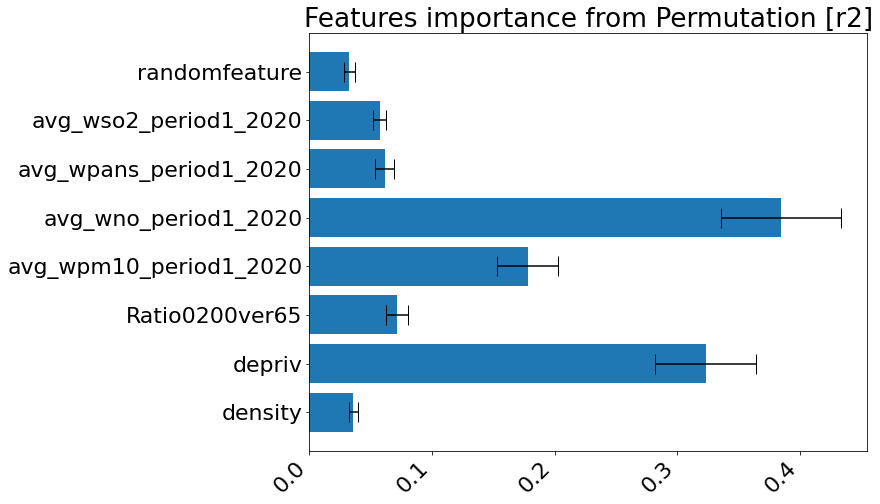

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04940 +/- 0.02989
Feature:                         depriv, Score: 0.09123 +/- 0.40532
Feature:                 Ratio0200ver65, Score: 0.09957 +/- 0.10004
Feature:         avg_wpm10_period1_2020, Score: 0.21479 +/- 0.11485
Feature:           avg_wno_period1_2020, Score: 0.31654 +/- 0.14418
Feature:         avg_wpans_period1_2020, Score: 0.00129 +/- 0.04158
Feature:          avg_wso2_period1_2020, Score: 0.03142 +/- 0.03149
Feature:                  randomfeature, Score: 0.01270 +/- 0.02787


<Figure size 432x288 with 0 Axes>

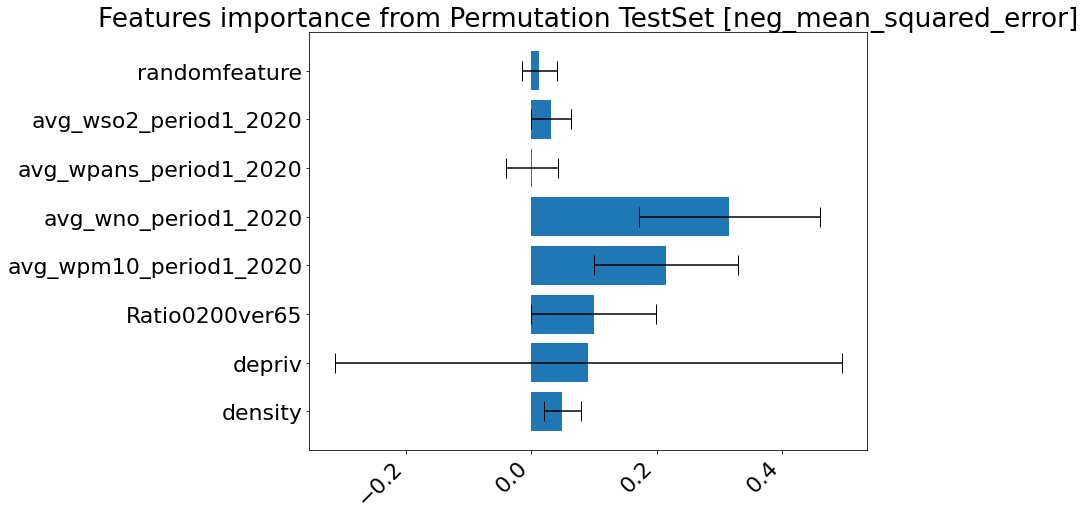

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.02106 +/- 0.01274
Feature:                         depriv, Score: 0.03889 +/- 0.17278
Feature:                 Ratio0200ver65, Score: 0.04244 +/- 0.04264
Feature:         avg_wpm10_period1_2020, Score: 0.09156 +/- 0.04896
Feature:           avg_wno_period1_2020, Score: 0.13493 +/- 0.06146
Feature:         avg_wpans_period1_2020, Score: 0.00055 +/- 0.01772
Feature:          avg_wso2_period1_2020, Score: 0.01340 +/- 0.01342
Feature:                  randomfeature, Score: 0.00541 +/- 0.01188


<Figure size 432x288 with 0 Axes>

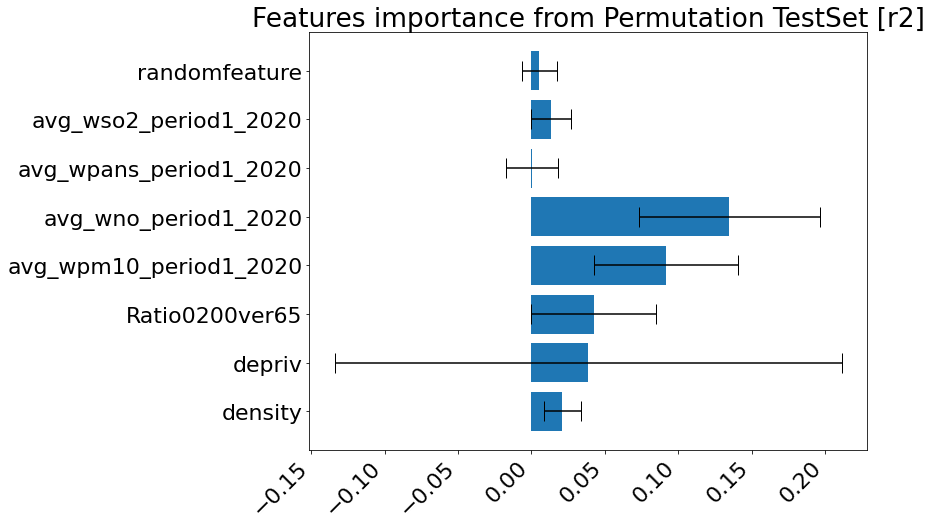

<Figure size 720x720 with 0 Axes>

((0.3947871366900303, 0.0215856727902293),
 (1.0829935051748827, 0.0939399692801764),
 0.38072749399715206,
 {'density': 0.03130659270615003,
  'depriv': 0.2824105299909433,
  'Ratio0200ver65': 0.06262156511788447,
  'avg_wpm10_period1_2020': 0.15546364828271766,
  'avg_wno_period1_2020': 0.3360783375930833,
  'avg_wpans_period1_2020': 0.05359648209827898,
  'avg_wso2_period1_2020': 0.04999058065297447,
  'randomfeature': 0.028532263557967896},
 {'density': 0.03130659270615002,
  'depriv': 0.28241052999094335,
  'Ratio0200ver65': 0.06262156511788446,
  'avg_wpm10_period1_2020': 0.15546364828271766,
  'avg_wno_period1_2020': 0.3360783375930833,
  'avg_wpans_period1_2020': 0.05359648209827899,
  'avg_wso2_period1_2020': 0.04999058065297449,
  'randomfeature': 0.028532263557967896},
 {'density': 0.06047301770880177,
  'depriv': 0.11167441200349576,
  'Ratio0200ver65': 0.12187802762653209,
  'avg_wpm10_period1_2020': 0.26292061526732285,
  'avg_wno_period1_2020': 0.38747337017266514,
  'av

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(besthyperF, best_rmse)
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_optallset", showplot=True, optimisedparams=besthyperF)

Qui invece ottimizzado RMSE sul testset

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10, 'random_state': 1, 'bootstrap': True, 'max_features': 'auto'} 0.0413616797680495 0.856538590909126 0.8151769111410765
Training set average RMSE:  0.78713  0.04675 
    Test set average RMSE:  0.91896  0.08849 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.77347
                       R2:  0.72623


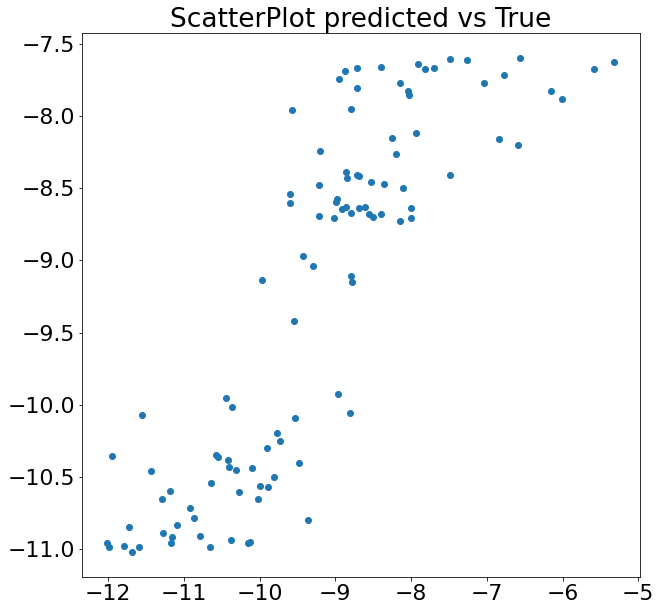

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.00375
Feature:               commutersdensity, Score: 0.00389
Feature:                         depriv, Score: 0.00404
Feature:                            lat, Score: 0.84836
Feature:                 Ratio0200ver65, Score: 0.02212
Feature:         avg_wpm10_period1_2020, Score: 0.02710
Feature:           avg_wno_period1_2020, Score: 0.07671
Feature:         avg_wpans_period1_2020, Score: 0.00404
Feature:          avg_wso2_period1_2020, Score: 0.00651
Feature:                  randomfeature, Score: 0.00346


<Figure size 432x288 with 0 Axes>

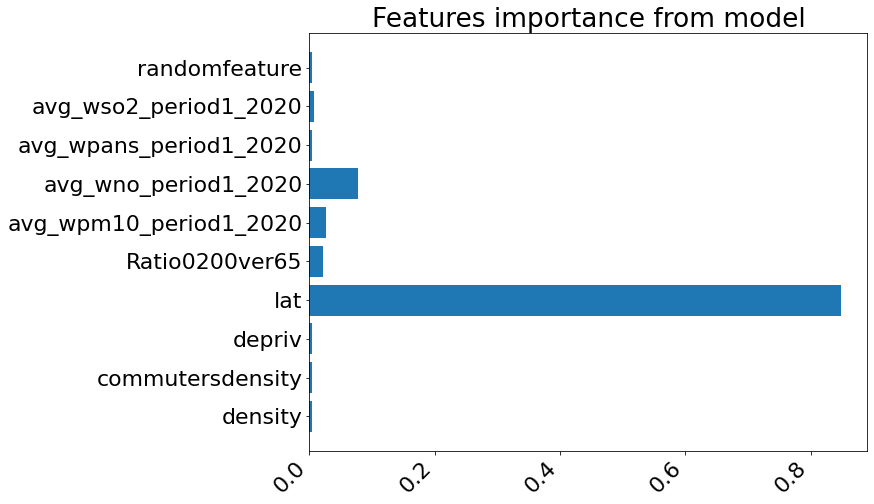

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05339 +/- 0.00605
Feature:               commutersdensity, Score: 0.02396 +/- 0.00320
Feature:                         depriv, Score: 0.05576 +/- 0.00630
Feature:                            lat, Score: 2.67437 +/- 0.36315
Feature:                 Ratio0200ver65, Score: 0.10364 +/- 0.01621
Feature:         avg_wpm10_period1_2020, Score: 0.20129 +/- 0.02543
Feature:           avg_wno_period1_2020, Score: 0.18693 +/- 0.02205
Feature:         avg_wpans_period1_2020, Score: 0.04052 +/- 0.00472
Feature:          avg_wso2_period1_2020, Score: 0.08120 +/- 0.01218
Feature:                  randomfeature, Score: 0.07653 +/- 0.01243


<Figure size 432x288 with 0 Axes>

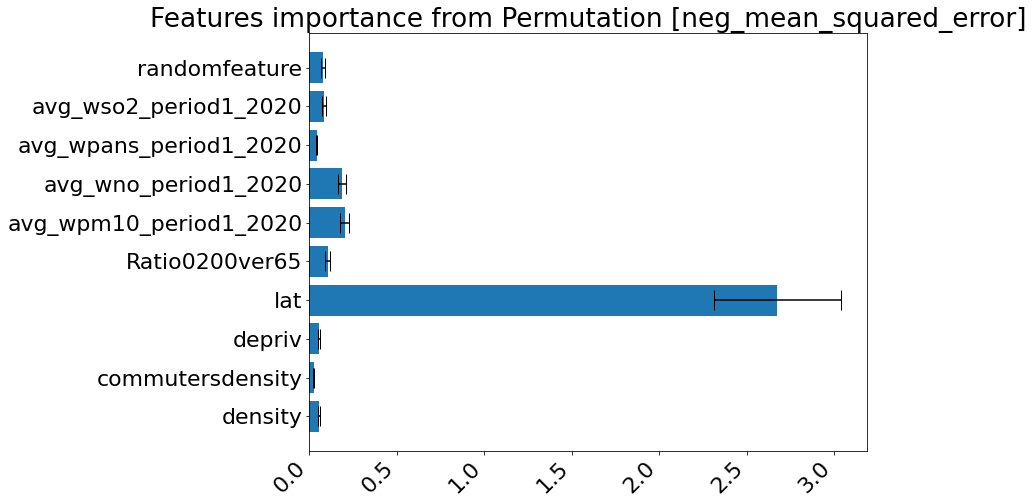

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02443 +/- 0.00277
Feature:               commutersdensity, Score: 0.01096 +/- 0.00146
Feature:                         depriv, Score: 0.02552 +/- 0.00288
Feature:                            lat, Score: 1.22383 +/- 0.16618
Feature:                 Ratio0200ver65, Score: 0.04743 +/- 0.00742
Feature:         avg_wpm10_period1_2020, Score: 0.09212 +/- 0.01164
Feature:           avg_wno_period1_2020, Score: 0.08554 +/- 0.01009
Feature:         avg_wpans_period1_2020, Score: 0.01854 +/- 0.00216
Feature:          avg_wso2_period1_2020, Score: 0.03716 +/- 0.00557
Feature:                  randomfeature, Score: 0.03502 +/- 0.00569


<Figure size 432x288 with 0 Axes>

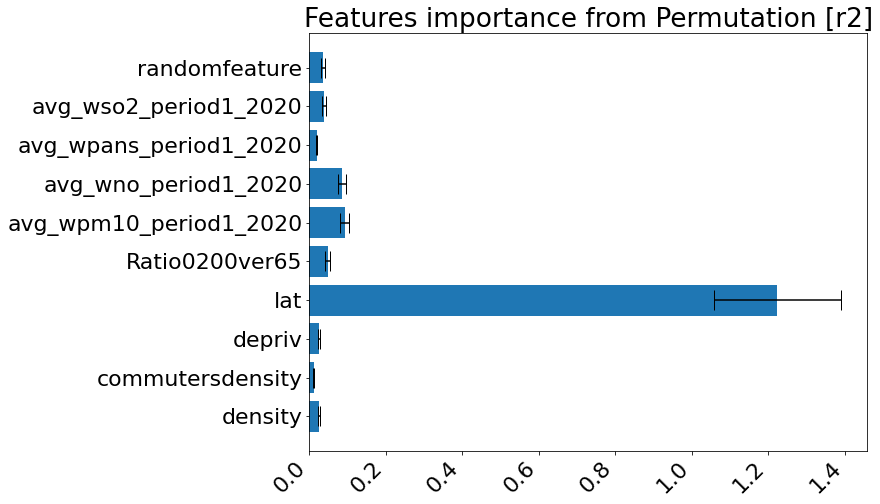

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00891 +/- 0.00978
Feature:               commutersdensity, Score: -0.00202 +/- 0.02309
Feature:                         depriv, Score: -0.07098 +/- 0.03350
Feature:                            lat, Score: 1.84293 +/- 0.40923
Feature:                 Ratio0200ver65, Score: 0.08671 +/- 0.12343
Feature:         avg_wpm10_period1_2020, Score: 0.01288 +/- 0.04531
Feature:           avg_wno_period1_2020, Score: 0.06725 +/- 0.03528
Feature:         avg_wpans_period1_2020, Score: -0.00876 +/- 0.01469
Feature:          avg_wso2_period1_2020, Score: -0.00258 +/- 0.01877
Feature:                  randomfeature, Score: -0.00194 +/- 0.02576


<Figure size 432x288 with 0 Axes>

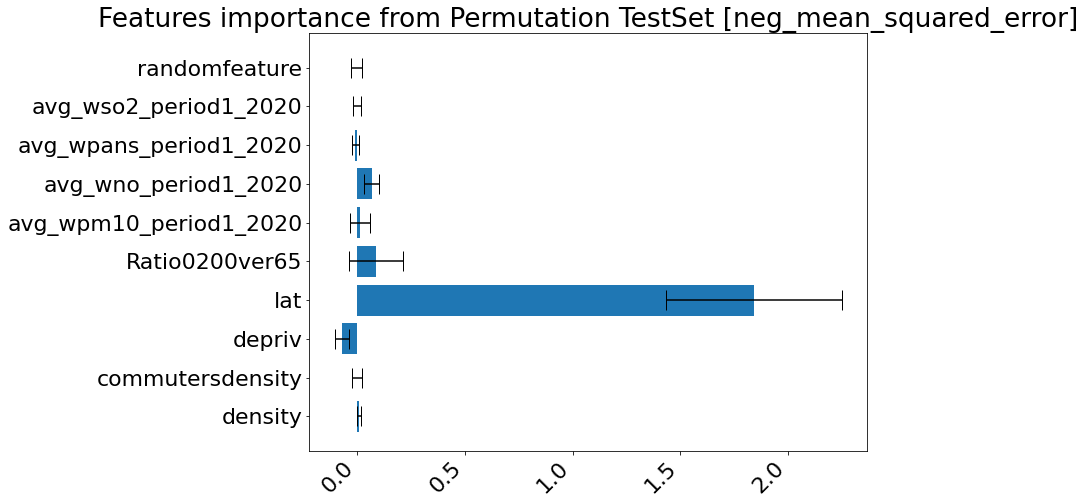

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00380 +/- 0.00417
Feature:               commutersdensity, Score: -0.00086 +/- 0.00984
Feature:                         depriv, Score: -0.03026 +/- 0.01428
Feature:                            lat, Score: 0.78559 +/- 0.17445
Feature:                 Ratio0200ver65, Score: 0.03696 +/- 0.05261
Feature:         avg_wpm10_period1_2020, Score: 0.00549 +/- 0.01931
Feature:           avg_wno_period1_2020, Score: 0.02867 +/- 0.01504
Feature:         avg_wpans_period1_2020, Score: -0.00373 +/- 0.00626
Feature:          avg_wso2_period1_2020, Score: -0.00110 +/- 0.00800
Feature:                  randomfeature, Score: -0.00083 +/- 0.01098


<Figure size 432x288 with 0 Axes>

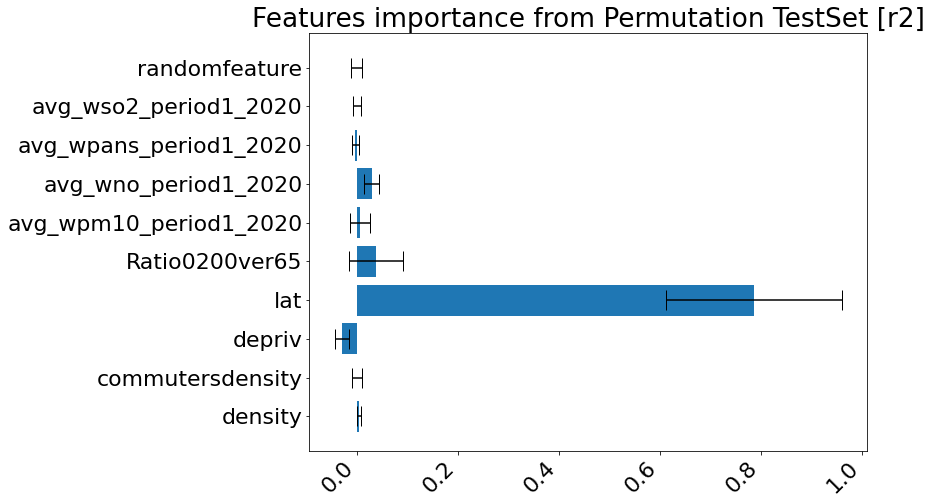

<Figure size 720x720 with 0 Axes>

((0.7871284291915986, 0.04675002739444215),
 (0.918962807292847, 0.0884938448346989),
 0.7734687640163828,
 {'density': 0.015265101528859038,
  'commutersdensity': 0.006849828680081131,
  'depriv': 0.015942608465626718,
  'lat': 0.7646289298027887,
  'Ratio0200ver65': 0.02963309445481903,
  'avg_wpm10_period1_2020': 0.057552198824818976,
  'avg_wno_period1_2020': 0.05344526767083542,
  'avg_wpans_period1_2020': 0.011585917287105988,
  'avg_wso2_period1_2020': 0.023215612843275144,
  'randomfeature': 0.021881440441789884},
 {'density': 0.015265101528859043,
  'commutersdensity': 0.006849828680081136,
  'depriv': 0.015942608465626725,
  'lat': 0.7646289298027886,
  'Ratio0200ver65': 0.02963309445481903,
  'avg_wpm10_period1_2020': 0.05755219882481895,
  'avg_wno_period1_2020': 0.05344526767083542,
  'avg_wpans_period1_2020': 0.011585917287105988,
  'avg_wso2_period1_2020': 0.02321561284327515,
  'randomfeature': 0.021881440441789884},
 {'density': 0.004612034499638072,
  'commutersdensit

In [12]:
# here we test grid opt to get a model not overfitting 

importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_opttestset", showplot=True, optimisedparams=besthyperF)

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.5696230496985514 0.9417524097821849 0.3721293600836335
Training set average RMSE:  0.38107  0.02604 
    Test set average RMSE:  1.01498  0.10428 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36000
                       R2:  0.94069


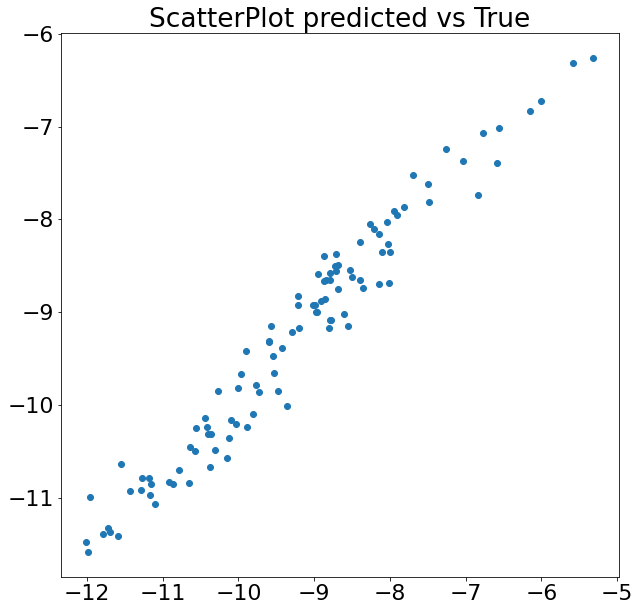

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05537
Feature:               commutersdensity, Score: 0.23046
Feature:                         depriv, Score: 0.15638
Feature:                 Ratio0200ver65, Score: 0.07205
Feature:         avg_wpm10_period1_2020, Score: 0.15176
Feature:           avg_wno_period1_2020, Score: 0.17990
Feature:         avg_wpans_period1_2020, Score: 0.04412
Feature:          avg_wso2_period1_2020, Score: 0.06765
Feature:                  randomfeature, Score: 0.04232


<Figure size 432x288 with 0 Axes>

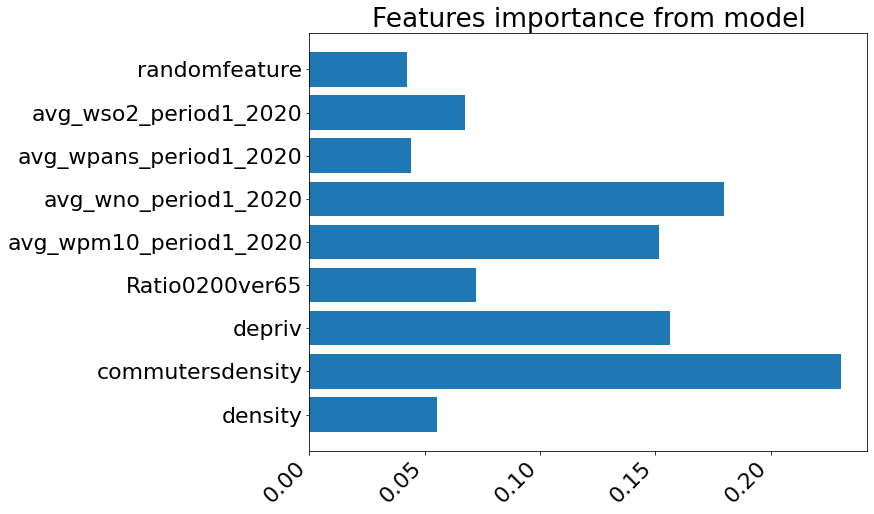

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04384 +/- 0.00422
Feature:               commutersdensity, Score: 1.60142 +/- 0.21071
Feature:                         depriv, Score: 0.05875 +/- 0.00769
Feature:                 Ratio0200ver65, Score: 0.19171 +/- 0.02271
Feature:         avg_wpm10_period1_2020, Score: 0.24487 +/- 0.03380
Feature:           avg_wno_period1_2020, Score: 0.39582 +/- 0.04619
Feature:         avg_wpans_period1_2020, Score: 0.08943 +/- 0.01116
Feature:          avg_wso2_period1_2020, Score: 0.11167 +/- 0.01092
Feature:                  randomfeature, Score: 0.06906 +/- 0.01078


<Figure size 432x288 with 0 Axes>

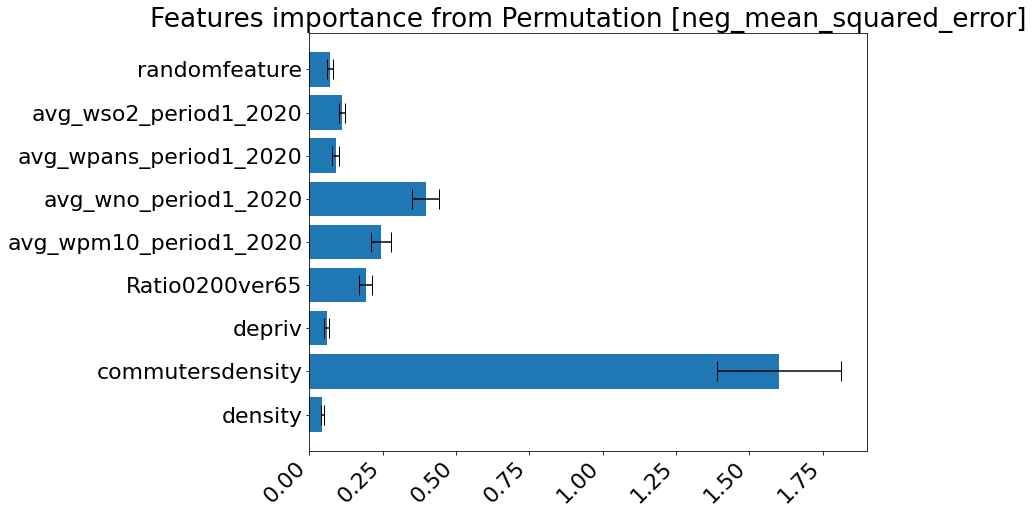

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02006 +/- 0.00193
Feature:               commutersdensity, Score: 0.73283 +/- 0.09643
Feature:                         depriv, Score: 0.02688 +/- 0.00352
Feature:                 Ratio0200ver65, Score: 0.08773 +/- 0.01039
Feature:         avg_wpm10_period1_2020, Score: 0.11206 +/- 0.01547
Feature:           avg_wno_period1_2020, Score: 0.18113 +/- 0.02114
Feature:         avg_wpans_period1_2020, Score: 0.04092 +/- 0.00511
Feature:          avg_wso2_period1_2020, Score: 0.05110 +/- 0.00500
Feature:                  randomfeature, Score: 0.03160 +/- 0.00493


<Figure size 432x288 with 0 Axes>

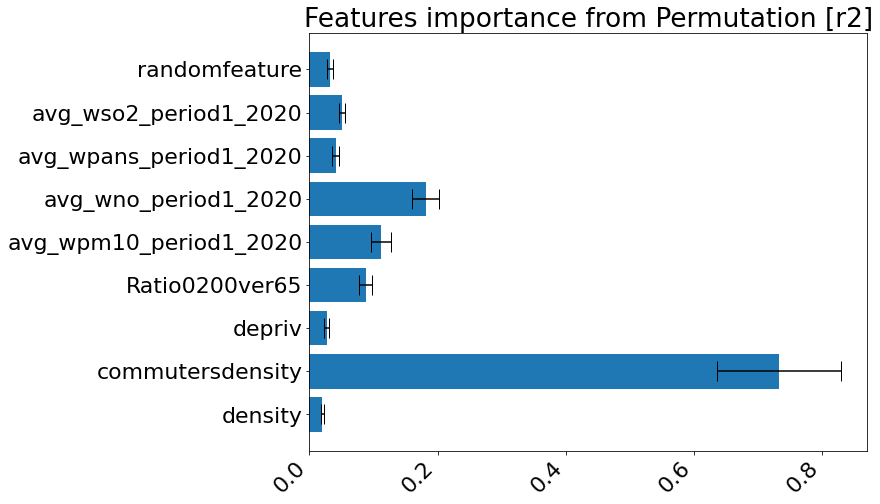

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01903 +/- 0.01650
Feature:               commutersdensity, Score: 1.09410 +/- 0.36422
Feature:                         depriv, Score: -0.10972 +/- 0.08253
Feature:                 Ratio0200ver65, Score: 0.22918 +/- 0.12516
Feature:         avg_wpm10_period1_2020, Score: 0.21509 +/- 0.12182
Feature:           avg_wno_period1_2020, Score: 0.15577 +/- 0.06252
Feature:         avg_wpans_period1_2020, Score: 0.03451 +/- 0.03506
Feature:          avg_wso2_period1_2020, Score: 0.02884 +/- 0.02552
Feature:                  randomfeature, Score: 0.01673 +/- 0.03958


<Figure size 432x288 with 0 Axes>

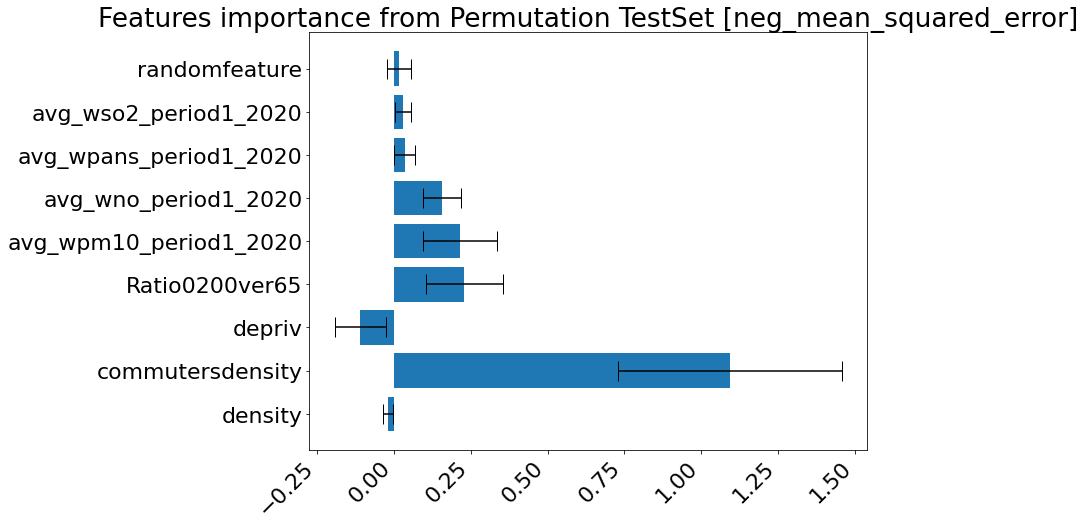

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00811 +/- 0.00703
Feature:               commutersdensity, Score: 0.46639 +/- 0.15526
Feature:                         depriv, Score: -0.04677 +/- 0.03518
Feature:                 Ratio0200ver65, Score: 0.09769 +/- 0.05335
Feature:         avg_wpm10_period1_2020, Score: 0.09169 +/- 0.05193
Feature:           avg_wno_period1_2020, Score: 0.06640 +/- 0.02665
Feature:         avg_wpans_period1_2020, Score: 0.01471 +/- 0.01494
Feature:          avg_wso2_period1_2020, Score: 0.01230 +/- 0.01088
Feature:                  randomfeature, Score: 0.00713 +/- 0.01687


<Figure size 432x288 with 0 Axes>

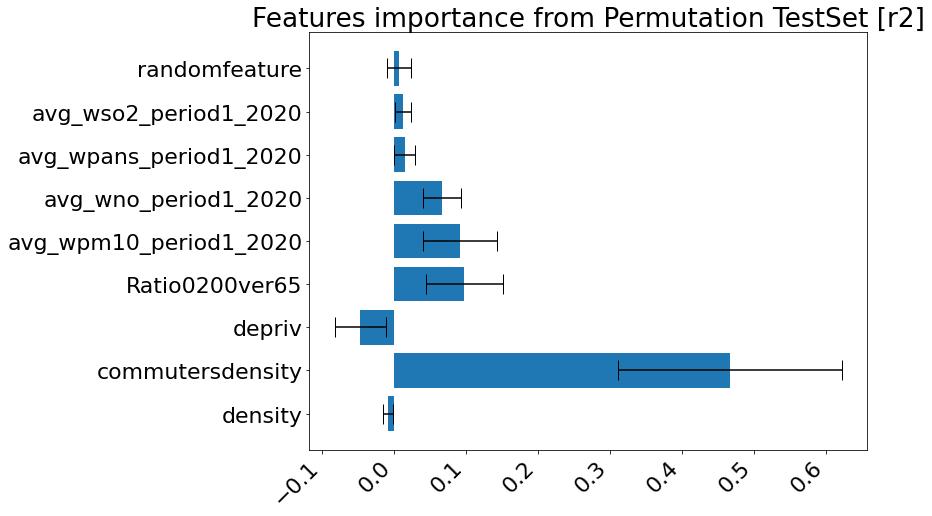

<Figure size 720x720 with 0 Axes>

((0.3810730448478543, 0.02603765735261447),
 (1.014978161953724, 0.1042798625729505),
 0.3600037646894367,
 {'density': 0.015622121081357581,
  'commutersdensity': 0.5705960949512513,
  'depriv': 0.020932434319146362,
  'Ratio0200ver65': 0.06830868499728998,
  'avg_wpm10_period1_2020': 0.08725008797517851,
  'avg_wno_period1_2020': 0.14103191437370896,
  'avg_wpans_period1_2020': 0.03186298267463891,
  'avg_wso2_period1_2020': 0.039790310198365146,
  'randomfeature': 0.024605369429063384},
 {'density': 0.015622121081357562,
  'commutersdensity': 0.5705960949512514,
  'depriv': 0.020932434319146348,
  'Ratio0200ver65': 0.06830868499728997,
  'avg_wpm10_period1_2020': 0.08725008797517851,
  'avg_wno_period1_2020': 0.141031914373709,
  'avg_wpans_period1_2020': 0.0318629826746389,
  'avg_wso2_period1_2020': 0.03979031019836513,
  'randomfeature': 0.024605369429063374},
 {'density': -0.011562392049824155,
  'commutersdensity': 0.664912205480142,
  'depriv': -0.06667872015289589,
  'Ratio02

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_opttestset", showplot=True, optimisedparams=besthyperF )

{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'random_state': 1, 'bootstrap': True, 'max_features': 'sqrt'} 0.45232285090908775 1.0119547945919096 0.5596319436828219
Training set average RMSE:  0.53229  0.02330 
    Test set average RMSE:  1.07660  0.09158 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.51743
                       R2:  0.87748


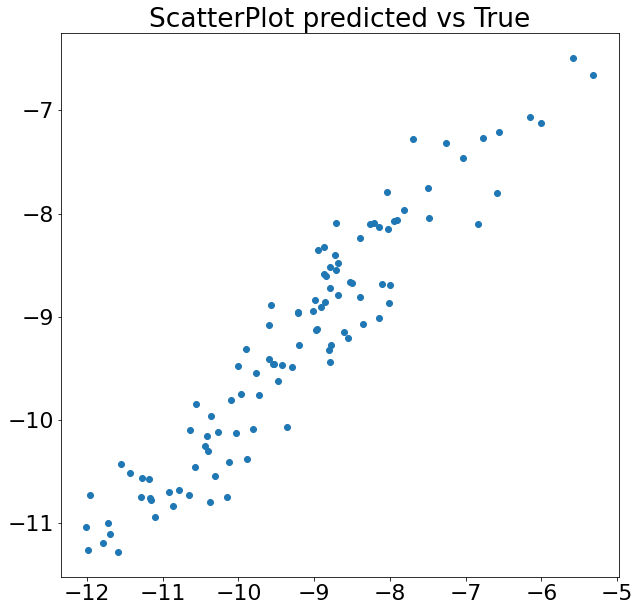

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.06856
Feature:                         depriv, Score: 0.18859
Feature:                 Ratio0200ver65, Score: 0.08518
Feature:         avg_wpm10_period1_2020, Score: 0.20376
Feature:           avg_wno_period1_2020, Score: 0.23771
Feature:         avg_wpans_period1_2020, Score: 0.07061
Feature:          avg_wso2_period1_2020, Score: 0.08772
Feature:                  randomfeature, Score: 0.05787


<Figure size 432x288 with 0 Axes>

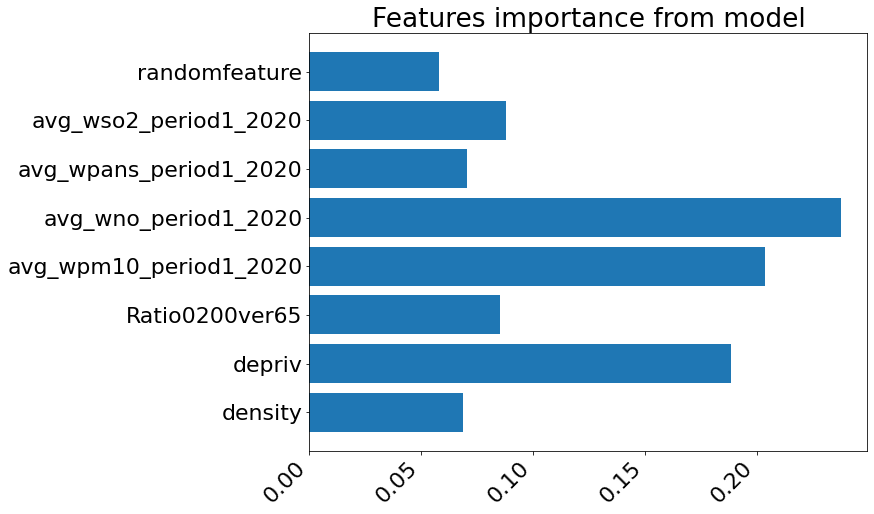

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05974 +/- 0.00705
Feature:                         depriv, Score: 0.61658 +/- 0.08015
Feature:                 Ratio0200ver65, Score: 0.18515 +/- 0.02374
Feature:         avg_wpm10_period1_2020, Score: 0.45630 +/- 0.06959
Feature:           avg_wno_period1_2020, Score: 0.88687 +/- 0.11209
Feature:         avg_wpans_period1_2020, Score: 0.12403 +/- 0.01340
Feature:          avg_wso2_period1_2020, Score: 0.11905 +/- 0.01319
Feature:                  randomfeature, Score: 0.06649 +/- 0.01023


<Figure size 432x288 with 0 Axes>

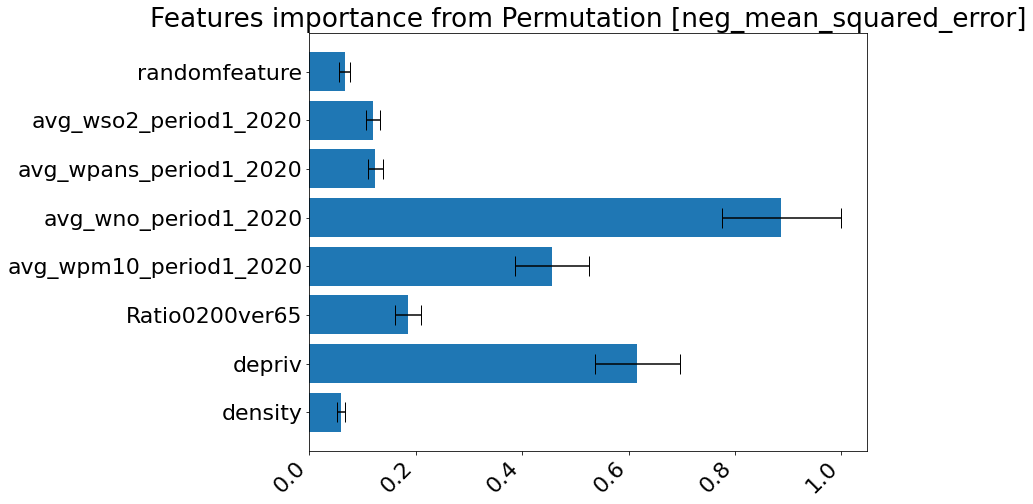

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02734 +/- 0.00323
Feature:                         depriv, Score: 0.28216 +/- 0.03668
Feature:                 Ratio0200ver65, Score: 0.08473 +/- 0.01087
Feature:         avg_wpm10_period1_2020, Score: 0.20881 +/- 0.03184
Feature:           avg_wno_period1_2020, Score: 0.40585 +/- 0.05129
Feature:         avg_wpans_period1_2020, Score: 0.05676 +/- 0.00613
Feature:          avg_wso2_period1_2020, Score: 0.05448 +/- 0.00604
Feature:                  randomfeature, Score: 0.03043 +/- 0.00468


<Figure size 432x288 with 0 Axes>

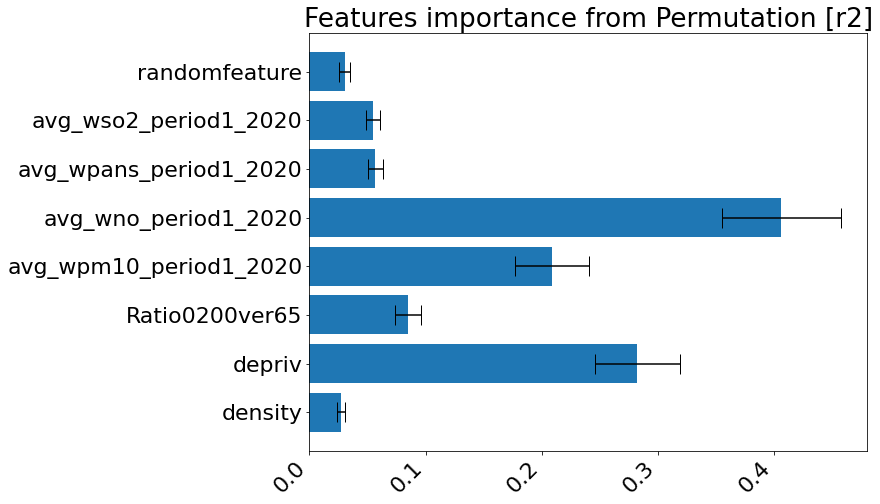

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.02493 +/- 0.02729
Feature:                         depriv, Score: 0.09810 +/- 0.37845
Feature:                 Ratio0200ver65, Score: 0.04910 +/- 0.09692
Feature:         avg_wpm10_period1_2020, Score: 0.22059 +/- 0.12148
Feature:           avg_wno_period1_2020, Score: 0.35165 +/- 0.15307
Feature:         avg_wpans_period1_2020, Score: 0.00191 +/- 0.04056
Feature:          avg_wso2_period1_2020, Score: 0.05773 +/- 0.03100
Feature:                  randomfeature, Score: 0.01918 +/- 0.02807


<Figure size 432x288 with 0 Axes>

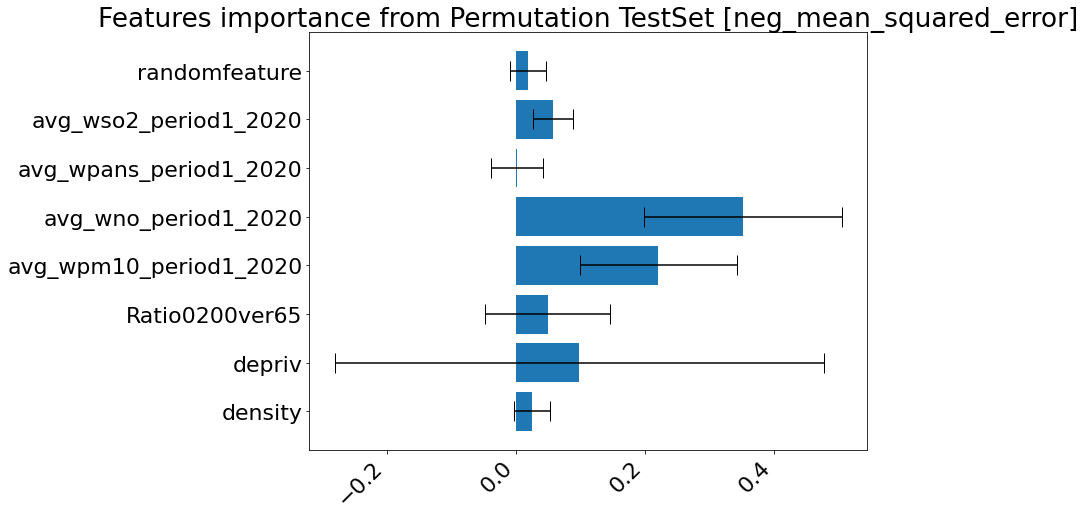

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.01063 +/- 0.01163
Feature:                         depriv, Score: 0.04182 +/- 0.16132
Feature:                 Ratio0200ver65, Score: 0.02093 +/- 0.04132
Feature:         avg_wpm10_period1_2020, Score: 0.09403 +/- 0.05178
Feature:           avg_wno_period1_2020, Score: 0.14990 +/- 0.06525
Feature:         avg_wpans_period1_2020, Score: 0.00082 +/- 0.01729
Feature:          avg_wso2_period1_2020, Score: 0.02461 +/- 0.01322
Feature:                  randomfeature, Score: 0.00818 +/- 0.01197


<Figure size 432x288 with 0 Axes>

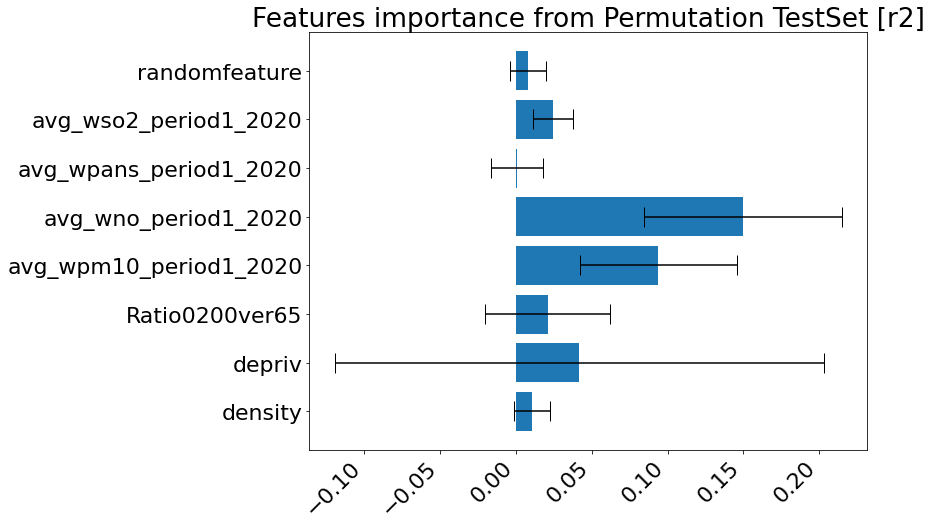

<Figure size 720x720 with 0 Axes>

((0.532291095390188, 0.023297648865702573),
 (1.0766040453609858, 0.09158405113816608),
 0.517434584933557,
 {'density': 0.023762633467403052,
  'depriv': 0.24523892949595852,
  'Ratio0200ver65': 0.07364281109846069,
  'avg_wpm10_period1_2020': 0.18148646537531019,
  'avg_wno_period1_2020': 0.3527430721438633,
  'avg_wpans_period1_2020': 0.049329556764614285,
  'avg_wso2_period1_2020': 0.04735001284392735,
  'randomfeature': 0.02644651881046258},
 {'density': 0.02376263346740307,
  'depriv': 0.2452389294959585,
  'Ratio0200ver65': 0.07364281109846069,
  'avg_wpm10_period1_2020': 0.18148646537531016,
  'avg_wno_period1_2020': 0.3527430721438633,
  'avg_wpans_period1_2020': 0.04932955676461431,
  'avg_wso2_period1_2020': 0.04735001284392735,
  'randomfeature': 0.0264465188104626},
 {'density': 0.030281416098947793,
  'depriv': 0.11917348645301604,
  'Ratio0200ver65': 0.05964641330221732,
  'avg_wpm10_period1_2020': 0.2679698054012914,
  'avg_wno_period1_2020': 0.4271726463416245,
  'avg_

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_opttestset", showplot=True, optimisedparams=besthyperF)